## Capstone Project 1 Proposal: Supplier Pricing Prediction & Cost Segmentation

### Project Scope: 
Caterpillar (construction equipment manufacturer) relies on a variety of suppliers to manufacture tube assemblies for their equipment. These assemblies are required in their equipment to lift, load and transport heavy construction loads. We are provided with detailed tube, component, and annual volume datasets. Our goal is to build and train a model that can predict how much a supplier will quote for a given tube assembly based on given supplier pricing, and use this information to further categorize assemblies and suppliers such that any movement in business criteria example recency, frequency, total spend, supplier rebates etc can be accurately classified and responded with appropriate supplier strategy. 

Project will be divided in two sections. 

1. Section 1 : Predict Supplier Pricing.
2. Section 2: Categorize Assembly & Suppliers

### Challenges: 
We are provided with 21 tables. Challenge is to come up with a consolidated table with an equation (relevant features) that can predict supplier pricing. Reason, our model should demonstrate that by varying assembly specifications, supplier predicted pricing is also getting impacted. Example, tube assembly without an additonal attachement should cost less compared to others. Also, assembly which is used to be purchased by a tier 1 supplier (based on highest total spend) is now a tier 2 suppplier due to significant reduction in business spend. 

How to build a consolidated table so that we can build the model is a challenge.

### Problem Solving: 
1. Built primary table using left merge on tube_assembly_id.
2. **Updated:  Dropped 22 and 59 columns from primary and secondary table contaning null values > 77%.
3. **Updated: Build secondary table by concatenating columns instead of using left merge. This helped reduce null values in the secondary table. 
4. **Updated: Created classification criteria, category labelling completed. 
5. **Updated: Built Final Table which consists of Primary and Secondary tables.
6. **Updated: Tables (Final and Segmented) ready for modelling.
7. **Updated: Tried few different algorithms to predict supplier pricing. Random Forest resulted in least RMSE error and accurate predicted value using training data.   
8. **Updated: Used K-Mean algorithm to categorize assemblies and suppliers in to various buckets, which we will use to drive actionable insights. 

### Feature Engineering: 
1. **Updated: Reduced null values from the secondary and primary table and kept limited yet relevant features to build the final table. 
2. **Updated: Developed pre-classification criteria such as recency, frequency, total spend, rebate, market difficulty, length of contract relationship, supplier preference etc to benchmark assemblies and suppliers.  

### Model Selection: 
Used models such as Linear Regression, Decision Tree, Random forest, PCA, and K-means to evlaute models and capture business insights.  

### Picture of the Tube Assembly:
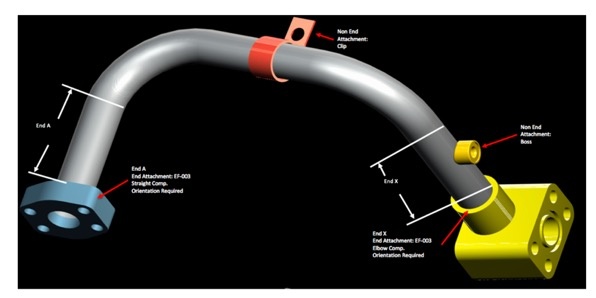

# Section1: Modelling for Supplier Pricing Prediction: 

## Section A.  Build Primary Table using left merge contaning Common Tube_Assembly_Id: 

### Step1. Load Libraries: 

In [4]:
#Load libraries except ML Libraries, which are loaded in later sections:

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import glob as gl

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### Step2. Build Primary Table:

In [5]:
#Load Dataset having common tube_assembly_id as the primary key:

#1.Tube
df_tube = pd.read_csv('tube.csv')

#2. Bill of material
df_bill = pd.read_csv('bill_of_materials.csv')

#3. Specifications
df_spec = pd.read_csv('specs.csv')

#4. Tube End form: (This is merged with the final table in the later section)
df_end_form = pd.read_csv('tube_end_form.csv')

#5. Training
df_train= pd.read_csv('train_set.csv',parse_dates=True) 

#### Re-Arrange Bill of Material Table: 

In [6]:
#View Table
df_bill.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate number of components and quantities required for each tube assembly: 
Example TA-00001 has two component_id's each requiring 2 quantities:
1. Equation = Sum of product of component_id and quantities 

In [7]:
#Count of component_id's in each tube assembly:
df_bill_comp= df_bill.groupby('tube_assembly_id')['component_id_1','component_id_2', 'component_id_3','component_id_4','component_id_5','component_id_6', 'component_id_7','component_id_8'].nunique()

#Quantity of each component_id per assembly: 
df_bill_cqty= df_bill.groupby('tube_assembly_id')['quantity_1','quantity_2', 'quantity_3','quantity_4','quantity_5','quantity_6', 'quantity_7','quantity_8'].sum()


#Optional: Above cade can be re-written as: 
#df_bill_comp= df_bill.groupby(['tube_assembly_id'])['component_id_1','component_id_2', 'component_id_3', 'component_id_4', 'component_id_5', 'component_id_6', 'component_id_7','component_id_8'].apply(lambda x: x.count())    
#df_bill_cqty= df_bill.groupby(['tube_assembly_id'])['quantity_1','quantity_2', 'quantity_3', 'quantity_4', 'quantity_5', 'quantity_6', 'quantity_7','component_id_8'].apply(lambda x: x.sum())

In [8]:
#Calculate total count of components in each assembly: 
df_bill_comp['count_compid'] = (df_bill_comp['component_id_1']
                                 + df_bill_comp['component_id_2'] 
                                 + df_bill_comp['component_id_3'] 
                                 + df_bill_comp['component_id_4'] 
                                 + df_bill_comp['component_id_5']
                                 + df_bill_comp['component_id_6'] 
                                 + df_bill_comp['component_id_7'] 
                                 + df_bill_comp['component_id_8']) 


#Calculate total quantities in each assembly:
df_bill_cqty['sum_qtyid'] = (df_bill_cqty['quantity_1'] 
                                 + df_bill_cqty['quantity_2']
                                 + df_bill_cqty['quantity_3']
                                 + df_bill_cqty['quantity_4']
                                 + df_bill_cqty['quantity_5']
                                 + df_bill_cqty['quantity_6']     
                                 + df_bill_cqty['quantity_7']
                                 + df_bill_cqty['quantity_8']) 

# Calculate sum of product of components and quantities in each tube assembly:  
sum_compqty_id = ((df_bill_comp['component_id_1']) * (df_bill_cqty['quantity_1']) 
                                 + (df_bill_comp['component_id_2']) * (df_bill_cqty['quantity_2'])
                                 + (df_bill_comp['component_id_3']) * (df_bill_cqty['quantity_3'])
                                 + (df_bill_comp['component_id_4']) * (df_bill_cqty['quantity_4'])
                                 + (df_bill_comp['component_id_5']) * (df_bill_cqty['quantity_5'])
                                 + (df_bill_comp['component_id_6']) * (df_bill_cqty['quantity_6'])
                                 + (df_bill_comp['component_id_7']) * (df_bill_cqty['quantity_7'])
                                 + (df_bill_comp['component_id_8']) * (df_bill_cqty['quantity_8']))



In [9]:
#View table: 
df_bill_comp.head()

,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8,count_compid
tube_assembly_id,,,,,,,,,
TA-00001,1,1,0,0,0,0,0,0,2
TA-00002,1,0,0,0,0,0,0,0,1
TA-00003,1,0,0,0,0,0,0,0,1
TA-00004,1,0,0,0,0,0,0,0,1
TA-00005,1,1,1,0,0,0,0,0,3


In [10]:
#View Table: 
df_bill_cqty.head()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,sum_qtyid
tube_assembly_id,,,,,,,,,
TA-00001,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
TA-00002,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00003,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00004,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00005,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [11]:
sum_compqty_id.head()

tube_assembly_id
TA-00001    4.0
TA-00002    2.0
TA-00003    2.0
TA-00004    2.0
TA-00005    3.0
dtype: float64

#### Treating Null Values in BOM table 

In [12]:
#checking for columns with less than 31 percent of null data
bill_31= df_bill.isnull().sum()/df_bill.shape[0]*100 < 31 #data up to 69% of not null values

#checking for columns with less than 76 percent of null data
bill_77=  df_bill.isnull().sum()/df_bill.shape[0]*100 < 77 #data upto 24% of not null values 

#Checking impact of dropping columns
bill_77.value_counts()-bill_31.value_counts()
bill_77

tube_assembly_id     True
component_id_1       True
quantity_1           True
component_id_2       True
quantity_2           True
component_id_3      False
quantity_3          False
component_id_4      False
quantity_4          False
component_id_5      False
quantity_5          False
component_id_6      False
quantity_6          False
component_id_7      False
quantity_7          False
component_id_8      False
quantity_8          False
dtype: bool

### Observation: 
1. Columns between 31% and 77% of null values have no impact on bill of materials table. 
2. As a result, following columns would represent hard to predict assemblies with fewer examples. 
3. After building our model, we can assess impact by adding back dropped columns.

### Dropped Columns: 
a) component_id_3 to component_id_4
 
b) quantity_3 to quantity_8    

In [13]:
#Hence , rejecting 77% of the Null values:
bill_77=(df_bill.isnull().sum()/df_bill.shape[0]* 100)<77
bill = df_bill.loc[:,bill_77]
bill.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2
0,TA-00001,C-1622,2.0,C-1629,2.0
1,TA-00002,C-1312,2.0,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0


#### Re-contruct bill table containing component Id's and quantities rows wise instead of column: 

In [14]:
# Apply Equation = Sum of product of component_id and quantities 
tube_comp_qty=sum_compqty_id

#Converting series tube_comp_qty to dataframe
df_tube_comp_qty=pd.DataFrame(tube_comp_qty, columns=['tube_comp_qty'])

# Rounding off result to 1 decimal place
df_tube_comp_qty=df_tube_comp_qty.round(decimals=1).reset_index()

#View table:
df_tube_comp_qty.head()

,tube_assembly_id,tube_comp_qty
0,TA-00001,4.0
1,TA-00002,2.0
2,TA-00003,2.0
3,TA-00004,2.0
4,TA-00005,3.0


In [15]:
#Merge df_final_bill with df_tube_comp_qty:
df_bill_final = pd.merge(left = bill, right= df_tube_comp_qty, on = 'tube_assembly_id', how = 'inner')

In [16]:
#View table:
df_bill_final.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,tube_comp_qty
0,TA-00001,C-1622,2.0,C-1629,2.0,4.0
1,TA-00002,C-1312,2.0,NaN,NaN,2.0
2,TA-00003,C-1312,2.0,NaN,NaN,2.0
3,TA-00004,C-1312,2.0,NaN,NaN,2.0
4,TA-00005,C-1624,1.0,C-1631,1.0,3.0


In [17]:
# Check if tube_comp_qty amount is correct: 
df_bill_final[df_bill_final['tube_assembly_id']=='TA-00001']

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,tube_comp_qty
0,TA-00001,C-1622,2.0,C-1629,2.0,4.0


#### Merge other primary tables with training dataset using left join. 

In [18]:
#Test: Replace df_bill with df_bill_final to recreate final table:
# First Merge: Train data with bill of material
df_first= pd.merge(left = df_train, right = df_bill_final, how = 'left', on = 'tube_assembly_id')

# Second Merge: First Merged table with tube
df_second= pd.merge(left = df_first, right = df_tube, how = 'left', on = 'tube_assembly_id')

# Third Merge: Second Merged table with Specs
df_third= pd.merge(left = df_second, right = df_spec, how = 'left', on = 'tube_assembly_id')

df_third.head()

#Tube end form will be merged later.

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Checking Null Values in the Primary table
#Rejecting 77% of the Null values:
prime_77= (df_third.isnull().sum()/df_third.shape[0]*100) < 77
prime_77= df_third.loc[:,prime_77]
prime_77.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


#### Merge Tube end form to build final primary table:

In [20]:
# View table: 
df_end_form.head()

,end_form_id,forming
0,EF-001,Yes
1,EF-002,No
2,EF-003,No
3,EF-004,No
4,EF-005,Yes


In [21]:
#Merge end_a
prime_77_end = pd.merge(left = prime_77, right= df_end_form, left_on = 'end_a', right_on = 'end_form_id', how = 'left')

#Rename column name
prime_77_end=prime_77_end.rename(columns={'forming': 'forming_end_a'})

#Drop column:
prime_77_end.drop(columns= 'end_form_id', axis = 1, inplace=True)

#View table: 
prime_77_end.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes


In [22]:
#Merge end_x
prime_77_final = pd.merge(left = prime_77_end, right= df_end_form, left_on = 'end_x', right_on = 'end_form_id', how = 'left')

#Rename column name
prime_77_final=prime_77_final.rename(columns={'forming': 'forming_end_x'})

#Drop Column: 
prime_77_final=prime_77_final.drop('end_form_id', axis = 1)

#View Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes


#### EDA Prime Table: 

In [23]:
#Check Statistics: 
prime_77_final.describe()

,annual_usage,min_order_quantity,quantity,cost,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30213.000000,30213.000000,30213.000000,30213.000000,28751.000000,21084.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317,1.641021,1.566591,2.926125,17.223018,1.384782,97.647605,3.813061,42.231223,0.025254,0.003542,0.013603
std,1590.331872,12.742776,70.761392,28.663200,0.488404,0.504756,1.176712,18.125973,0.638610,63.230131,2.199564,200.313458,0.184975,0.069664,0.150840
min,0.000000,0.000000,1.000000,0.503553,1.000000,1.000000,0.000000,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.878190,1.000000,1.000000,2.000000,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,10.000000,6.521146,2.000000,2.000000,3.000000,12.700000,1.240000,86.000000,3.000000,31.750000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,40.000000,13.431781,2.000000,2.000000,4.000000,19.050000,1.650000,133.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,150000.000000,535.000000,2500.000000,1000.000000,4.000000,4.000000,13.000000,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,3.000000,8.000000


### Observation: 
1. Bend_Radius max value = 9999.00
2. Max diameter = 203.2

#### Bend radius , Diameter and Number of Bends in the Tube Assembly:

In [24]:
#Check Relationship between Bend Radius and Diameter: 
prime_77_final[['tube_assembly_id', 'bend_radius', 'diameter', 'num_bends']][prime_77_final.diameter==203.2].sort_values(by = 'diameter',ascending= True).head()

,tube_assembly_id,bend_radius,diameter,num_bends
17498,TA-11307,0.0,203.2,0
17499,TA-11307,0.0,203.2,0
17500,TA-11307,0.0,203.2,0
17501,TA-11307,0.0,203.2,0
17502,TA-11307,0.0,203.2,0


Text(0.5,1,'Bend Radius, Tube Diameter and Number of Bends')

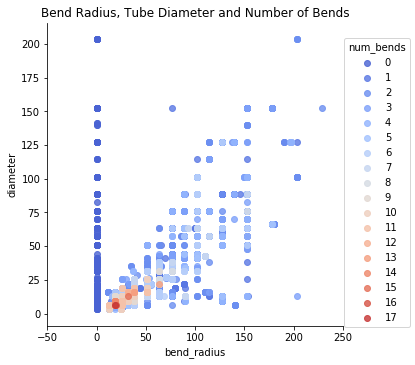

In [25]:
#Visualize Bend Radius, Tube Diameter and Number of Bends :
sns.lmplot(x='bend_radius', y = 'diameter', data = prime_77_final, fit_reg= False, hue = 'num_bends', palette='coolwarm')
plt.xlim(-50,250)
plt.title('Bend Radius, Tube Diameter and Number of Bends')

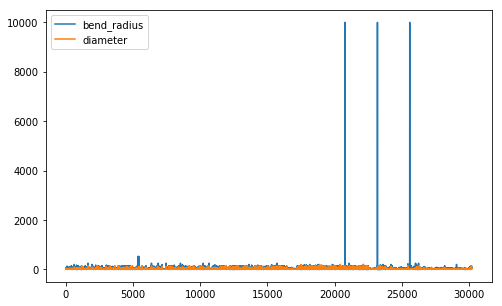

In [26]:
#Check if Bend Radius > tube radius:
prime_77_final[['bend_radius', 'diameter']].plot(kind = 'line', figsize= (8,5))

#### Observation:
1. Some observations have a max bend radius of 9999. 

In [27]:
#Check if an assembly with zero bend_radius have any bends:
prime_77_final[['tube_assembly_id', 'bend_radius', 'diameter', 'num_bends']][prime_77_final.diameter==203.2]

,tube_assembly_id,bend_radius,diameter,num_bends
17498,TA-11307,0.0,203.2,0
17499,TA-11307,0.0,203.2,0
17500,TA-11307,0.0,203.2,0
17501,TA-11307,0.0,203.2,0
17502,TA-11307,0.0,203.2,0
17503,TA-11310,0.0,203.2,0
18895,TA-13050,0.0,203.2,0
20400,TA-14710,0.0,203.2,0
22147,TA-16763,203.2,203.2,2
22148,TA-16763,203.2,203.2,2


#### Observation
1. Shows Linear relationship when bend_radius > 0.
2. Some observations have bend_radius = 0
3. For max tube diameter 203.2, I am limiting the max bend_radius to a standard minimum of 7 times the tube diameter = 203.2*7. This will avoid modelling errors due to bend radius values =9999. At 7D, a large bend becomes closer to being a straught tube.
4. Bend_radius values > 203.2 are outliers and should be replaced.
5. Assemblies with zero bend radius and zero bends shall have no bend processing cost.
6. Max bends are found in assemblies with bend radius under 51.
7. Some tube assemblies with maximum diameter are supplied with no bends.
8. Some observations of bend radius were found greater than the tube diameter. 

###### Link Bend Radius Design: https://www.listertube.com/links/tube-bending-design-guide/
##### THE KEY RULES OF THUMB ARE;
##### Select a standard tube size
##### a) For small bend radii keep to one bend radius if possible and use radius of 2 x D
##### b) For larger bend radii keep to greater than 7 x D.



(2.0, 1500)

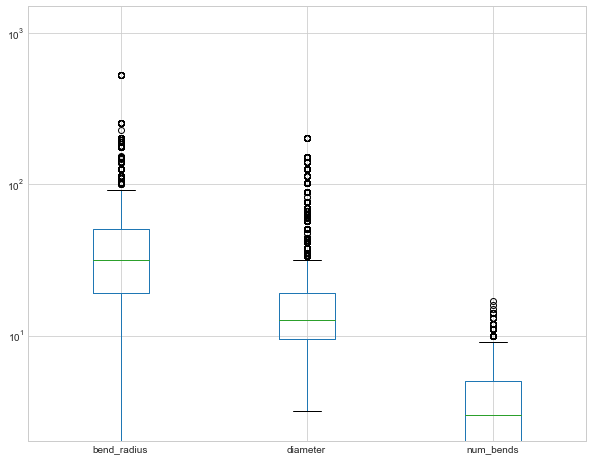

In [28]:
#Explore outliers in bend radius and Diameter:
sns.set_style('whitegrid')
prime_77_final[['bend_radius', 'diameter', 'num_bends']].plot(kind= 'box', logy= True, figsize= (10, 8))
#sns.boxplot(y = 'bend_radius', data = prime_77_final)
plt.ylim(0,1500)

#### Treat Outliers in Bend_Radius

In [29]:
#Calculate Inter Quartile Range: 
q1= prime_77_final['bend_radius'].quantile(0.25)
q2 = prime_77_final['bend_radius'].quantile(0.75)
iqr = q2-q1
print('Inter Quartile Range:', iqr)

Inter Quartile Range: 31.749999999999996


In [30]:
#Replace outliers in bend_radius > greater than tube radius with maximum value of possible tube radius:
prime_77_final['bend_radius'][prime_77_final['bend_radius']>203.2*7]=(prime_77_final['bend_radius'][prime_77['bend_radius']>203.2*7]).replace(to_replace=prime_77['bend_radius'][prime_77_final['bend_radius']>203.2*7], value= 203.2*7)

In [31]:
#View Final Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes


In [32]:
#### Check Bend_Radius, Diameter and Number of Bends in the tube assembly:
prime_77_final[['bend_radius', 'diameter', 'num_bends']].describe()

,bend_radius,diameter,num_bends
count,30213.000000,30213.000000,30213.000000
mean,38.824769,17.223018,3.813061
std,38.650233,18.125973,2.199564
min,0.000000,3.180000,0.000000
25%,19.050000,9.520000,2.000000
50%,31.750000,12.700000,3.000000
75%,50.800000,19.050000,5.000000
max,1422.400000,203.200000,17.000000


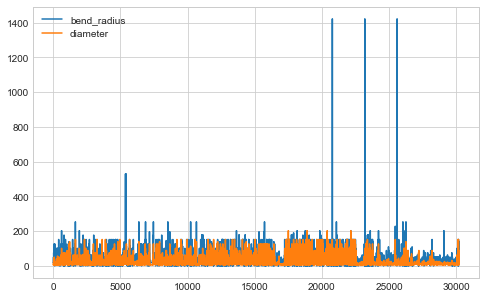

In [33]:
#Visualize if outliers in Bend Radius were capped to half of maximum diameter value 
prime_77_final[['bend_radius', 'diameter']].plot(figsize= (8, 5))

#### Observtaion: 
1. Capped Max Bend radius to minimum design standard of 7 * Tube Diameter.  

#### Order Quanity, Minimum Order Quanity, Annual Usage and Cost: 

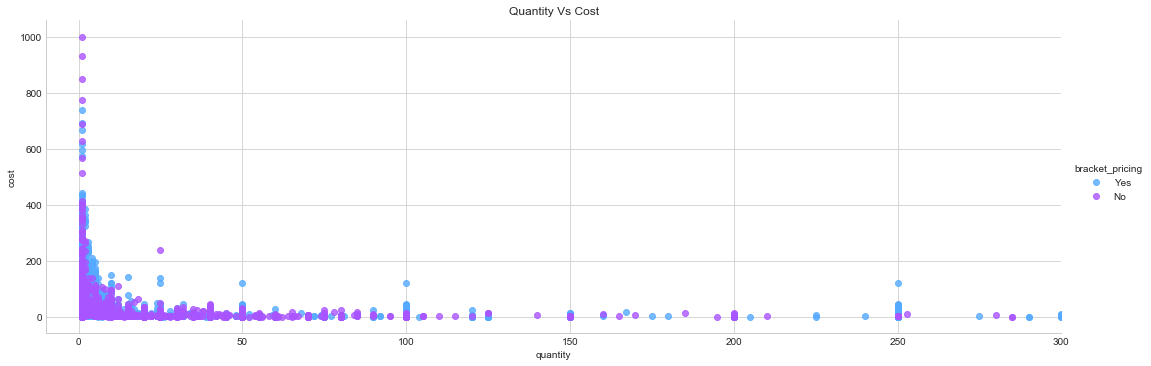

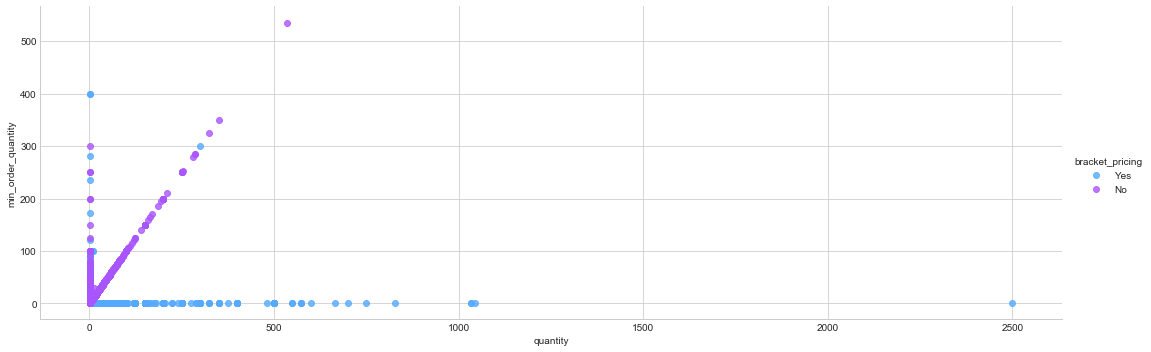

In [34]:
#Order Quantity Vs Cost:
#plt.figure(figsize= (20,20))

sns.lmplot(x = 'quantity', y = 'cost', data = prime_77_final, hue = 'bracket_pricing', fit_reg=False, palette= 'cool', aspect=3)
plt.xlim(-10, 300)
plt.title('Quantity Vs Cost')


sns.lmplot(y = 'min_order_quantity', x = 'quantity', data = prime_77_final, hue = 'bracket_pricing', fit_reg=False, palette= 'cool', aspect=3)

In [35]:
#1.Grouping Merged table by tube assembly, bracket pricing and quantity:
df1 =prime_77_final.groupby(['tube_assembly_id', 'bracket_pricing', 'quantity'])['cost'].apply(list).head(10)
df2= prime_77_final.groupby(['tube_assembly_id', 'bracket_pricing', 'quantity'])['cost'].apply(list).tail(10)
df_priceview = pd.concat([df1,df2])
print('Bracket Pricing:', '\n', df_priceview)

#2.Do we have tube assemblies where suppliers have quoted both bracket and non-bracket pricing?
assert prime_77_final[(prime_77_final['bracket_pricing']== 'Yes') & (prime_77_final['bracket_pricing']=='No')].all().all()


#3.Is there a variation in non-bracket pricing with the increase in quantity
print('Non Bracket Pricing:','\n',prime_77_final[prime_77_final['bracket_pricing']=='No'].groupby(['tube_assembly_id','quantity'])['cost'].apply(list).head())

Bracket Pricing: 
 tube_assembly_id  bracket_pricing  quantity
TA-00002          Yes              1           [21.905933019146104]
                                   2             [12.3412139792904]
                                   5            [6.601826143565379]
                                   10             [4.6877695119712]
                                   25          [3.5415611802607296]
                                   50          [3.2244064477000696]
                                   100           [3.08252143576504]
                                   250           [2.99905966403855]
TA-00004          Yes              1             [21.9727024365273]
                                   2             [12.4079833966715]
TA-21189          Yes              2           [12.163162199607198]
                                   5             [6.42655642293975]
                                   10            [4.51249979134557]
                                   25            [3.3

#### Observation: 
1. Lower the order quantity higher the price.  
2. Some observations have both bracket and non-bracket pricing plotted along x and y axis. 
4. Check for conflicting observations if quantity value is same as the minimum order quantity. 
5. Supplier provides one type of pricing. Both bracket and non-bracket pricing is not observed.
6. Non-bracket supplier pricing is fixed to minimum order quantity.

#### Find and fix quantity miss-match where 'minimum order quantity' is neither 'zero' nor equal to 'quantity':

#### a) Verify quantity miss-match:

In [36]:
#Select minimum order quantity which is neither 0 or equate to quantity value:
df_check=prime_77_final[(prime_77_final['quantity']!=prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity']!=0)].sort_values('bracket_pricing', ascending=False)

In [37]:
#See Result:
print('Quantity Miss-Match:' '\n', df_check[['bracket_pricing','min_order_quantity','quantity','cost']].head(10), '\n', df_check[['bracket_pricing','min_order_quantity','quantity','cost']].tail(10))

Quantity Miss-Match:
       bracket_pricing  min_order_quantity  quantity       cost
16423             Yes                  40         1   3.193804
16076             Yes                  25         1   3.057483
16072             Yes                   2         1  25.555995
16033             Yes                  11         1   6.693634
15888             Yes                  12         1   7.400277
15886             Yes                  21        20   4.518064
15885             Yes                  20         1   6.276325
15884             Yes                  12         1   7.336290
15713             Yes                   4         1   3.040791
15291             Yes                  17         1   6.924545 
       bracket_pricing  min_order_quantity  quantity       cost
17605              No                  10         1  25.678405
17573              No                  17         1   3.867062
17572              No                   5         1  27.726001
5625               No          

### Observation: 
1. Minimum order quantity is not equal to quantity for both bracket and non bracket pricing. 
2. This will lead to pricing error because supplier cost is based on minimum order quantity and not per unit cost.

#### b) Fix non-bracket quantity miss-match:

In [38]:
#Select quantity miss-match and replace it with minimum order quantity.
prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
         & (prime_77_final['bracket_pricing'] == 'No')] = (prime_77_final[(prime_77['quantity']!= prime_77_final['min_order_quantity'])& (prime_77_final['min_order_quantity'] !=0)
                                                                & (prime_77_final['bracket_pricing'] == 'No')]).assign(quantity = prime_77_final['min_order_quantity'])

#### c) Fix bracket quantity miss-match:

In [39]:
#Bracket Pricing: Select quantity miss-match and replace it with minimum order quantity.
(prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
          & (prime_77_final['bracket_pricing'] == 'Yes')]) = (prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
                                                                & (prime_77_final['bracket_pricing'] == 'Yes')]).assign(quantity = prime_77_final['min_order_quantity'])

#### d) Verify if quantity miss match is fixed:

In [40]:
## See Result: Empty Dataframne where minimum order quantity is not equal to zero as well as quantity. 
print('Fixed if Result Returns Empty DataFrame:','\n',prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity']!=0)])

Fixed if Result Returns Empty DataFrame: 
 Empty DataFrame
Columns: [tube_assembly_id, supplier, quote_date, annual_usage, min_order_quantity, bracket_pricing, quantity, cost, component_id_1, quantity_1, component_id_2, quantity_2, tube_comp_qty, material_id, diameter, wall, length, num_bends, bend_radius, end_a_1x, end_a_2x, end_x_1x, end_x_2x, end_a, end_x, num_boss, num_bracket, other, forming_end_a, forming_end_x]
Index: []

[0 rows x 30 columns]


### Add Feature: Calculate Supplier Rebate Pricing:

#### Supplier Rebate based quantity (1-2, 1-5, 1-10 ..)

In [41]:
#Using lambda expression:
prime_77_final['%supplier_rebate']=prime_77_final.groupby(['tube_assembly_id', 'quantity','cost'][0])['cost'].apply(lambda x: abs((x-x.max())/x.max())* 100)
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,0.000000
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,43.662687
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,69.862840
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,78.600457
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,83.832868


count    30213.000000
mean        49.220586
std         35.983698
min          0.000000
25%          0.000000
50%         66.486139
75%         81.766382
max         98.327120
Name: %supplier_rebate, dtype: float64


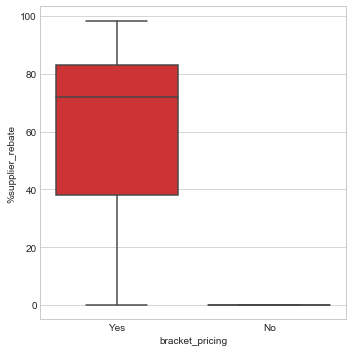

In [42]:
#Explore %Supplier Rebate based two differnt pricing Types:
plt.figure(figsize= (5,5))
sns.boxplot(x= 'bracket_pricing', y = '%supplier_rebate', data = prime_77_final, palette='Set1')
plt.tight_layout()
print(prime_77_final['%supplier_rebate'].describe())

#### Observation:
1. Non-Bracket Pricing has no Supplier Rebate
2. Bracket pricing supplier rebate range from 0-98%

### Calculate Extended and Total Cost: 

#### Extended Cost = quantity * cost

In [43]:
#Multiply cost with quantity:
prime_77_final['extended_cost'] = prime_77_final['quantity']*prime_77_final['cost'] 

#### Total Cost = Annual usage * Extended cost/quantity 

In [44]:
#Add total cost based on annual usage: 
prime_77_final['total_cost'] = (prime_77_final['annual_usage'] * prime_77_final['cost'])/prime_77_final['quantity']

In [45]:
#View Prime Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate,extended_cost,total_cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,EF-008,EF-008,0,0,0,Yes,Yes,0.000000,21.905933,0.0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,EF-008,EF-008,0,0,0,Yes,Yes,43.662687,24.682428,0.0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,EF-008,EF-008,0,0,0,Yes,Yes,69.862840,33.009131,0.0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,EF-008,EF-008,0,0,0,Yes,Yes,78.600457,46.877695,0.0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,EF-008,EF-008,0,0,0,Yes,Yes,83.832868,88.539030,0.0


In [46]:
prime_77_final.isnull().sum()

tube_assembly_id         0
supplier                 0
quote_date               0
annual_usage             0
min_order_quantity       0
bracket_pricing          0
quantity                 0
cost                     0
component_id_1        1462
quantity_1            1462
component_id_2        9129
quantity_2            9129
tube_comp_qty            0
material_id            229
diameter                 0
wall                     0
length                   0
num_bends                0
bend_radius              0
end_a_1x                 0
end_a_2x                 0
end_x_1x                 0
end_x_2x                 0
end_a                    0
end_x                    0
num_boss                 0
num_bracket              0
other                    0
forming_end_a          926
forming_end_x         1315
%supplier_rebate         0
extended_cost            0
total_cost               0
dtype: int64

In [47]:
prime_77_final.columns

Index(['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage',
       'min_order_quantity', 'bracket_pricing', 'quantity', 'cost',
       'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2',
       'tube_comp_qty', 'material_id', 'diameter', 'wall', 'length',
       'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other',
       'forming_end_a', 'forming_end_x', '%supplier_rebate', 'extended_cost',
       'total_cost'],
      dtype='object')

### Add Feature: Calculate Tube Area

In [48]:
# Calculate Surface area: 2Π(R²-r²)+2Πh(R+r)
#Tube radius from center to outer surface:
R = prime_77_final['diameter']/2

# Tube radius from cetnter to inner surface: R - 2* wall 
r = R- (2 * prime_77_final['wall'])
 
#Height of the tube is tube length: 
h = prime_77_final['length']

prime_77_final['area'] = (2*3.14 * ((R*R) - (r*r))) + (2 * 3.14 * (R + r))
prime_77_final['area']=prime_77_final['area'].round(decimals=2)
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate,extended_cost,total_cost,area
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,0.000000,21.905933,0.0,74.92
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,43.662687,24.682428,0.0,74.92
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,69.862840,33.009131,0.0,74.92
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,78.600457,46.877695,0.0,74.92
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,83.832868,88.539030,0.0,74.92


#### Other Observations: 

In [49]:
#Unique Categorical values: 
prime_77_final[prime_77_final.select_dtypes(['object']).columns].nunique()

tube_assembly_id    8855
supplier              57
quote_date          1781
bracket_pricing        2
component_id_1       642
component_id_2       452
material_id           17
end_a_1x               2
end_a_2x               2
end_x_1x               2
end_x_2x               2
end_a                 25
end_x                 24
forming_end_a          2
forming_end_x          2
dtype: int64

In [50]:
#Number of Tube Assemblies per Supplier: 
print('Top 5 Suppliers supplying maximum assortment of tube assemblies:' '\n','\n',prime_77_final.groupby(['supplier'])['tube_assembly_id'].nunique().sort_values(ascending= False).head())

Top 5 Suppliers supplying maximum assortment of tube assemblies:
 
 supplier
S-0066    3530
S-0041    1536
S-0072    1459
S-0026     552
S-0013     535
Name: tube_assembly_id, dtype: int64


## Section B: Build Secondary Table by Concatenating Assembly Components Containing Common Component_Id:

In [51]:
#load component tables and merge along seconday key component_id 
tables = ['components.csv',
          'comp_adaptor.csv',
          'comp_boss.csv', 
          'comp_elbow.csv',
          'comp_float.csv', 
          'comp_hfl.csv', 
          'comp_nut.csv', 
          'comp_other.csv', 
          'comp_sleeve.csv', 
          'comp_straight.csv', 
          'comp_tee.csv', 
          'comp_threaded.csv']

df_comps = [pd.read_csv(table) for table in tables]

#Concatenate Vertically:
df_comps_2 = pd.concat(df_comps, axis='rows')
df_comps_2.head()

,adaptor_angle,base_diameter,base_type,blind_hole,bolt_pattern_long,bolt_pattern_wide,component_id,component_type_id,connection_type_id,connection_type_id_1,...,thread_pitch_3,thread_pitch_4,thread_size,thread_size_1,thread_size_2,thread_size_3,thread_size_4,type,unique_feature,weight
0,NaN,NaN,NaN,NaN,NaN,NaN,9999,OTHER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,C-0001,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,C-0002,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,C-0003,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,C-0004,CP-026,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
#Checking Null Values in the Secondary table
#Rejecting 77% of the Null values:
comps_77=(df_comps_2.isnull().sum()/df_comps_2.shape[0]*100) < 77
comps_77 = df_comps_2.loc[:,comps_77]
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,NaN
1,C-0001,CP-024,SLEEVE,NaN,NaN,NaN,NaN
2,C-0002,CP-024,SLEEVE,NaN,NaN,NaN,NaN
3,C-0003,CP-024,SLEEVE-FLARED,NaN,NaN,NaN,NaN
4,C-0004,CP-026,NUT,NaN,NaN,NaN,NaN


In [53]:
#Identify null values in Components table before treatment:
before = comps_77.isnull().sum()
before

component_id            0
component_type_id    1001
name                 2048
orientation          3049
part_name            3094
unique_feature       3136
weight               2119
dtype: int64

#### Identify Fill Method:  

In [54]:
#1. Check if common component_ids have both null and non-null values: 
comps_77[['part_name','component_id', 'component_type_id', 'name', 'orientation', 'unique_feature', 'weight']][comps_77['component_id']=='C-0001']

,part_name,component_id,component_type_id,name,orientation,unique_feature,weight
1,NaN,C-0001,CP-024,SLEEVE,NaN,NaN,NaN
0,NaN,C-0001,CP-024,NaN,No,No,0.013


In [55]:
#2. Check if common component_ids have both null and non-null values: 
comps_77[['part_name','component_id', 'component_type_id', 'name', 'orientation', 'unique_feature']][comps_77['component_id']=='C-1364']

,part_name,component_id,component_type_id,name,orientation,unique_feature
1364,NaN,C-1364,OTHER,ELBOW-WATER,NaN,NaN
239,ELBOW-WATER,C-1364,NaN,NaN,NaN,NaN


#### Observation:
1. For weight/unique_feature/orientation/part_name: Use Back Fill Method. 
2. For component_type_id/name: Use Forward Fill method.  

### Treating Null Values in Components Table: 

In [56]:
#Treat Missing values for weight/unique_feature/orientation/part_name using backfill: 
comps_77[['weight', 'unique_feature', 'orientation', 'part_name']]=comps_77.groupby(['component_id'])['weight', 'unique_feature', 'orientation', 'part_name'].transform(lambda x: x.fillna(method = 'bfill'))

#Treat Description 
comps_77[['component_type_id', 'name']]=comps_77.groupby(['component_id'])['component_type_id', 'name'].transform(lambda x: x.fillna(method = 'ffill'))

In [57]:
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,NaN
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
3,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014
4,C-0004,CP-026,NUT,No,NaN,NaN,0.014


In [58]:
#Drop row where component_id = 9999
comps_77=comps_77.drop(comps_77.index[0])

#View Table: 
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
3,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014
4,C-0004,CP-026,NUT,No,NaN,NaN,0.014
5,C-0005,CP-028,ADAPTER-STR,No,NaN,No,0.206


In [59]:
#Compare null values after treatment:
after= comps_77.isnull().sum()
print('Before Null Treatment:' '\n',before, '\n', 'After Null Treatment:' '\n', after)

Before Null Treatment:
 component_id            0
component_type_id    1001
name                 2048
orientation          3049
part_name            3094
unique_feature       3136
weight               2119
dtype: int64 
 After Null Treatment:
 component_id            0
component_type_id       0
name                    2
orientation          2001
part_name            2082
unique_feature       2172
weight                142
dtype: int64


In [60]:
#Check non-null name values: 
#print(comps_77[comps_77['name'].notnull()])

#Drop name column 
#comps_77=comps_77.drop(columns= ['name'])

In [61]:
#Check Name Vs Part_Name Shape:
print('Name:', comps_77[comps_77['name'].notnull()].shape, 'Part_name:', comps_77[comps_77['part_name'].notnull()].shape)

#Identify Most used component names: 
print(comps_77['name'].value_counts().head())

Name: (4081, 7) Part_name: (2001, 7)
FLANGE    698
BOSS      303
ELBOW     259
PLATE     194
TUBE      182
Name: name, dtype: int64


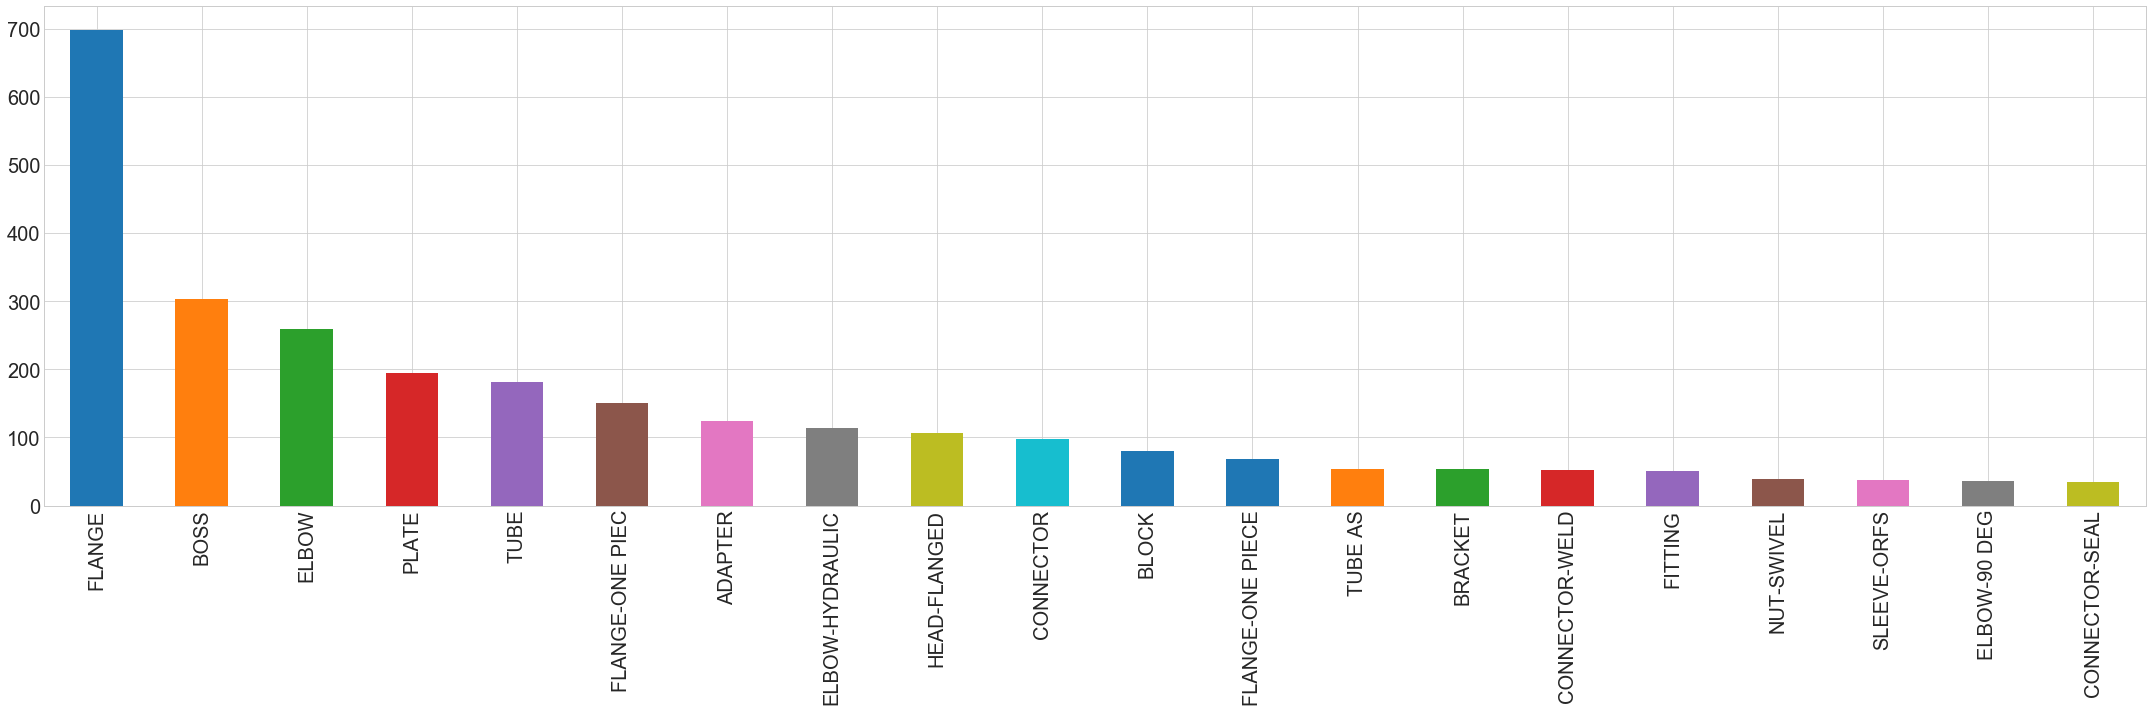

In [62]:
#Visualize top 20 frequently used part names :
plt.figure(figsize = (30, 10))
comps_77['name'].value_counts().head(20).plot(kind = 'bar', fontsize= 20)
plt.tight_layout()
plt.show()

## Section C:  Build Final Table Contaning Primary and Secondary Tables: 

In [63]:
#Merge primary table component_id_1 with secondary table on component_id: 
df_merge1=pd.merge(left = prime_77_final, right = comps_77, left_on= ['component_id_1'], right_on=['component_id'], how ='left')

#Rename merged component_id column to component_id_a:
df_merge1=df_merge1.rename(columns={'component_id': 'component_id_a'})

#View first final table 'df_final2' contaning common components_id_1, forming end_a and forming end_x: 
df_merge1.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,extended_cost,total_cost,area,component_id_a,component_type_id,name,orientation,part_name,unique_feature,weight
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
1,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
2,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
3,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
4,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,33.009131,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009


In [64]:
#Merge primary table component_id_2 with the secondary table on component_id: 
df_merge2=pd.merge(left = prime_77_final, right = comps_77, left_on= ['component_id_2'], right_on=['component_id'], how ='left')

#Rename merged component_id column to component_id_b
df_merge2=df_merge2.rename(columns={'component_id': 'component_id_b'})

#View first final table 'df_final2' contaning common components_id_1, forming end_a and forming end_x: 
df_merge2.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,extended_cost,total_cost,area,component_id_b,component_type_id,name,orientation,part_name,unique_feature,weight
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,33.009131,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,46.877695,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,88.539030,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
#Concatenate df_merge1 and df_merge2 tables: 
final_table = pd.concat([df_merge1, df_merge2], axis = 'rows')
final_table.head()

,%supplier_rebate,annual_usage,area,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,tube_comp_qty,unique_feature,wall,weight
0,0.000000,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
1,0.000000,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
2,43.662687,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
3,43.662687,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
4,69.862840,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009


In [66]:
final_table[final_table['tube_assembly_id']== 'TA-00005'].head()

,%supplier_rebate,annual_usage,area,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,tube_comp_qty,unique_feature,wall,weight
32,0.000000,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
33,0.000000,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
34,41.798216,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
35,41.798216,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
36,66.879106,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035


In [67]:
#Check for duplicates: 
final_table.drop_duplicates(inplace=True)

In [68]:
final_table.columns

Index(['%supplier_rebate', 'annual_usage', 'area', 'bend_radius',
       'bracket_pricing', 'component_id_1', 'component_id_2', 'component_id_a',
       'component_id_b', 'component_type_id', 'cost', 'diameter', 'end_a',
       'end_a_1x', 'end_a_2x', 'end_x', 'end_x_1x', 'end_x_2x',
       'extended_cost', 'forming_end_a', 'forming_end_x', 'length',
       'material_id', 'min_order_quantity', 'name', 'num_bends', 'num_boss',
       'num_bracket', 'orientation', 'other', 'part_name', 'quantity',
       'quantity_1', 'quantity_2', 'quote_date', 'supplier', 'total_cost',
       'tube_assembly_id', 'tube_comp_qty', 'unique_feature', 'wall',
       'weight'],
      dtype='object')

In [69]:
#Re-arrange column positions inside the table:
final_table= final_table.reindex_axis(labels=['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id','component_type_id',
       'component_id_1','component_id_a', 'quantity_1', 'component_id_2', 'component_id_b', 'quantity_2', 'tube_comp_qty',
       'diameter','wall', 'length', 'num_bends', 'bend_radius', 'area', 'end_a_1x', 'end_a_2x','forming_end_x',
       'end_x_1x', 'end_x_2x', 'end_a', 'forming_end_a', 'end_x', 'num_boss', 'num_bracket',
       'other','name','orientation', 'part_name', 'unique_feature', 'weight','quote_date', 'annual_usage', 'min_order_quantity', 'quantity',
       '%supplier_rebate', 'extended_cost','total_cost','cost'], axis=1)

In [70]:
print('Final Table Shape:',final_table.shape)
final_table.head()

Final Table Shape: (58964, 42)


,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,unique_feature,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
0,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,1,0.000000,21.905933,0.0,21.905933
2,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,2,43.662687,24.682428,0.0,12.341214
4,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,5,69.862840,33.009131,0.0,6.601826
6,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,10,78.600457,46.877695,0.0,4.687770
8,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,25,83.832868,88.539030,0.0,3.541561


## Section D: Treat Final_Tabel for Modelling: 

#### Convert Data Type

In [71]:
#Converting quotation date to date time format:
final_table['quote_date'] = pd.to_datetime(final_table['quote_date'])

#Converting Object columns in the dataframe into Category: 
final_table[final_table.select_dtypes(['object']).columns] = final_table.select_dtypes(['object']).apply(lambda x: x.astype('category'))

#Count of unique categorical values in the merged table:  
final_table[final_table.select_dtypes(['category']).columns].nunique()

tube_assembly_id     8855
supplier               57
bracket_pricing         2
material_id            17
component_type_id      26
component_id_1        642
component_id_a        642
component_id_2        452
component_id_b        452
end_a_1x                2
end_a_2x                2
forming_end_x           2
end_x_1x                2
end_x_2x                2
end_a                  25
forming_end_a           2
end_x                  24
name                  173
orientation             2
part_name             115
unique_feature          2
dtype: int64

#### Identify and Treat Remaning Null Values 

In [72]:
#Check null values:
final_table.isnull().sum()

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             457
component_type_id      9129
component_id_1         1462
component_id_a        30213
quantity_1             1462
component_id_2        16796
component_id_b        37880
quantity_2            16796
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x          2063
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a          1357
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                   9129
orientation           10847
part_name             57246
unique_feature        30274
weight                 9238
quote_date                0
annual_usage        

In [73]:
#Removing components with null values
final_table=final_table[final_table['component_id_1'].notnull()]

final_table=final_table[final_table['component_id_2'].notnull()]

#Removing orientation with null values: 
final_table=final_table[final_table['orientation'].notnull()]

#Removing unique features with null values: 
final_table=final_table[final_table['unique_feature'].notnull()]

#Removing forming_end_a null values: 
final_table=final_table[final_table['forming_end_a'].notnull()]

#Removing forming_end_x null values:
final_table=final_table[final_table['forming_end_x'].notnull()]

In [74]:
#Check Null Values:
final_table.isnull().sum()

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             207
component_type_id         0
component_id_1            0
component_id_a        18381
quantity_1                0
component_id_2            0
component_id_b         2714
quantity_2                0
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x             0
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a             0
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                      0
orientation               0
part_name             21095
unique_feature            0
weight                    8
quote_date                0
annual_usage        

#### Treat Weight Null Values: 
#### EDA Weight:

In [75]:
#View Weight Null Values: 
final_table[final_table['weight'].isnull()].head()

,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,unique_feature,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
16427,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2005-02-23,0,1,1,83.720220,1.482837,0.000000,1.482837
16429,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2014-08-08,64,0,50,0.000000,455.423068,11.658831,9.108461
16431,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2014-08-08,64,0,100,19.089798,736.967444,4.716592,7.369674
21918,TA-07237,S-0081,Yes,SP-0028,CP-004,C-0471,C-0471,1.0,C-0634,NaN,...,No,NaN,2013-10-15,1400,1,1,0.000000,3.463664,4849.128937,3.463664
21920,TA-07237,S-0081,Yes,SP-0028,CP-004,C-0471,C-0471,1.0,C-0634,NaN,...,No,NaN,2013-10-10,1400,1,1,0.000000,3.463664,4849.128937,3.463664


In [76]:
#Review Statistics: 
final_table.weight.describe()

count    21087.000000
mean         0.065761
std          0.307322
min          0.001000
25%          0.006000
50%          0.012000
75%          0.026000
max          9.805000
Name: weight, dtype: float64

In [77]:
#final_table[['weight', 'bend_radius', 'diameter']][final_table['weight'].isnull()]

In [78]:
# Filling null weight with Median to avoid outliers: 
def impute_weight(series):
    
    """
    impute_weight will calculate median and fillna values in the series with its median. 
    """
    
    return series.fillna(series.median())

final_table['weight'] = final_table['weight'].transform(impute_weight) 

#View null values: 
final_table.isnull().sum()
#Values for material_id, name, part_name will not be in modeeling, hence not treated:  

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             207
component_type_id         0
component_id_1            0
component_id_a        18381
quantity_1                0
component_id_2            0
component_id_b         2714
quantity_2                0
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x             0
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a             0
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                      0
orientation               0
part_name             21095
unique_feature            0
weight                    0
quote_date                0
annual_usage        

#### Weight Outliers

Text(0.5,1,'Weight Distribution Above 0.026 or 75 percentile')

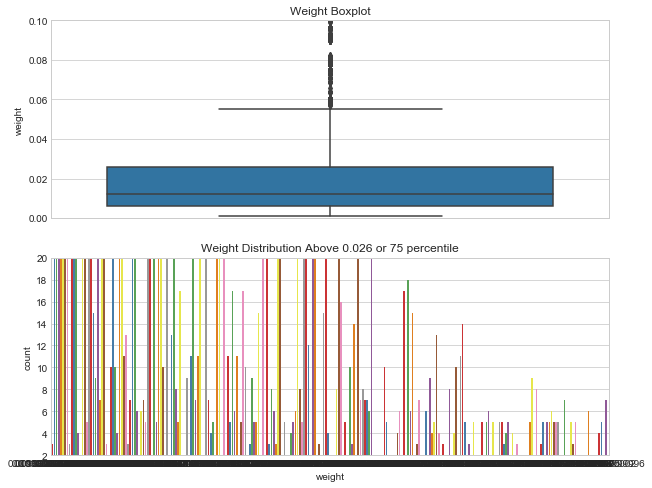

In [79]:
# Visualize Weight Outliers: 
plt.figure(figsize= (10,8))
sns.set_style('whitegrid')
plt.subplot(2,1,1)
sns.boxplot(y= 'weight', data = final_table)
plt.ylim(0,0.1)
plt.title('Weight Boxplot')
plt.subplot(2,1,2)
sns.countplot(x='weight', data = final_table, palette='Set1')
plt.ylim(ymin= 2, ymax= 20)
plt.title('Weight Distribution Above 0.026 or 75 percentile')

#### Weigth Distribution:

Text(0.5,1,'Weight Ditribution < ).026')

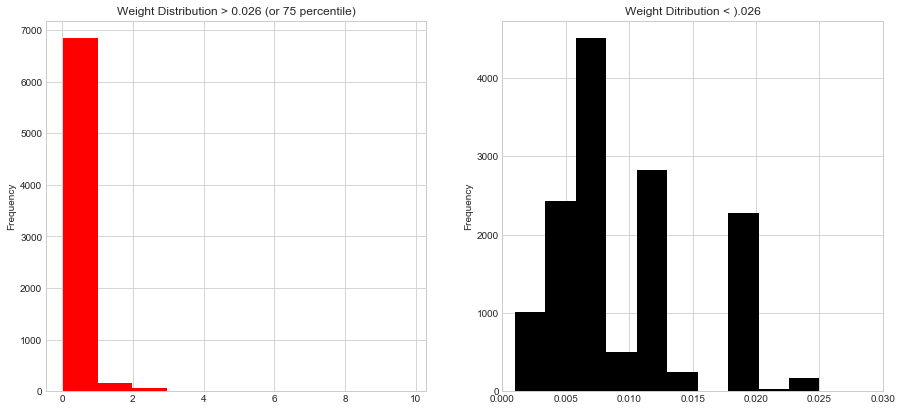

In [80]:
# Count weight values > 75% quartile range:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
final_table['weight'][final_table['weight'] > 0.026].plot(kind='hist', sharey= True, colors= 'red')
plt.title('Weight Distribution > 0.026 (or 75 percentile)')

# Count weight values < 75% quartile range
plt.subplot(2,2,2)
final_table['weight'][final_table['weight'] <= 0.026].plot(kind='hist', color= 'black')
plt.xlim(0,0.03)
plt.title('Weight Ditribution < ).026')

In [81]:
# Most Commonly Used Component Parts: 
print('Weight Range between 0 & 2:','\n',final_table['name'][(final_table['weight'] >=0) & (final_table['weight'] <=2)].value_counts().head())
print('Weight Range between 2 & 4:','\n',final_table['name'][(final_table['weight'] >=2) & (final_table['weight'] <=4)].value_counts().head())
print('Weight Range between 4 & 8:','\n',final_table['name'][(final_table['weight'] >4) & (final_table['weight'] <=8)].value_counts().head())
print('Weight Range between 8 & 14:','\n',final_table['name'][(final_table['weight'] >8) & (final_table['weight'] <=14)].value_counts().head())

Weight Range between 0 & 2: 
 SLEEVE-ORFS       13851
SLEEVE-FLARED      1767
SLEEVE             1493
CONNECTOR-SEAL      957
SLEEVE-FITTING      455
Name: name, dtype: int64
Weight Range between 2 & 4: 
 FLANGE              25
FLANGE-ONE PIEC     24
FLANGE-ONE PIECE    15
ELBOW                2
BLOCK                1
Name: name, dtype: int64
Weight Range between 4 & 8: 
 ELBOW-HYDRAULIC     5
FLANGE              4
BLOCK               1
WASHER-FUEL LIN     0
COUPLING (1"BSP)    0
Name: name, dtype: int64
Weight Range between 8 & 14: 
 ELBOW-HYDRAULIC    7
FLANGE             2
WASHER-FUEL LIN    0
COUPLET-WELD       0
ELB                0
Name: name, dtype: int64


Text(0.5,1,'Top 10 Parts in Weight Range 8-14')

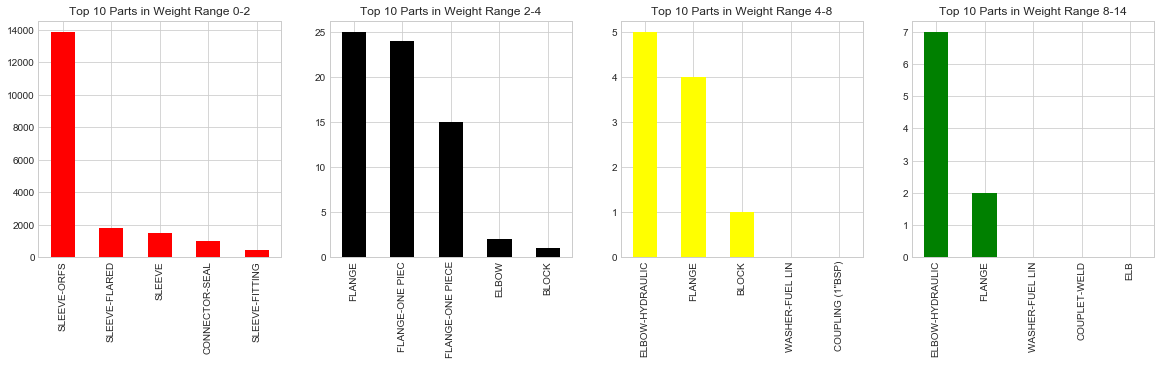

In [82]:
#Visualize top 10 most commonly used components parts in the assembly:
plt.figure(figsize=(20, 20))
plt.subplot(4,4,1)
final_table['name'][(final_table['weight'] >=0) & (final_table['weight'] <=2)].value_counts().head(5).plot(kind = 'bar', color='red')
plt.title('Top 10 Parts in Weight Range 0-2')
plt.subplot(4,4,2)
final_table['name'][(final_table['weight'] >=2) & (final_table['weight'] <=4)].value_counts().head(5).plot(kind = 'bar', color= 'black')
plt.title('Top 10 Parts in Weight Range 2-4')
plt.subplot(4,4,3)
final_table['name'][(final_table['weight'] >=4) & (final_table['weight'] <=8)].value_counts().head(5).plot(kind = 'bar', color= 'yellow')
plt.title('Top 10 Parts in Weight Range 4-8')
plt.subplot(4,4,4)
final_table['name'][(final_table['weight'] >=8) & (final_table['weight'] <=14)].value_counts().head(5).plot(kind = 'bar', color = 'green')
plt.title('Top 10 Parts in Weight Range 8-14')

#### Explore Relationships Between Cost and Input Variables:

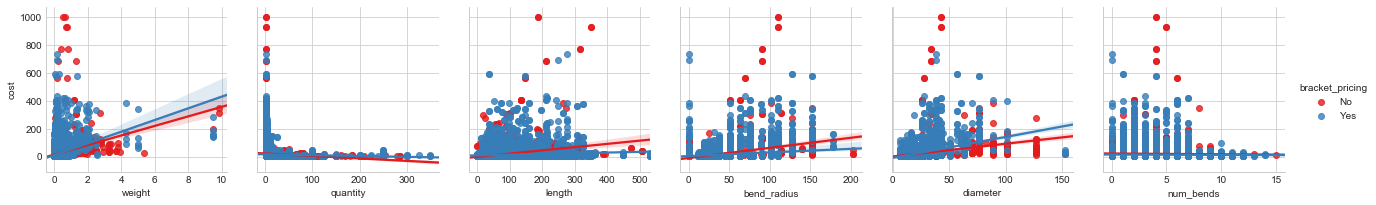

In [83]:
# Impact of input variables on Cost as a result of Bracket Pricing:
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='bracket_pricing', size = 3, palette='Set1', kind= 'reg')

#### Observation: 
1. Cost increases with increase in weight/length/bend_radius/diameter. 
2. Cost decreases with increase in order quantity. 
3. Heavy weight and big diameter assemblies purchased in bulk have higher cost increase compared to min-order. 
4. Cost is not effected by increase in number of bends.

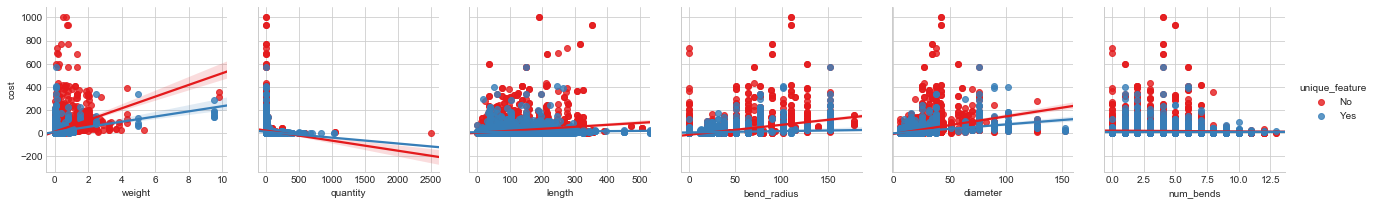

In [84]:
#Impact of input variables on Cost as a result of Unique Features:
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='unique_feature', size = 3, palette='Set1', kind= 'reg')

#### Observation: 
1. Assemblies with Unique features have lower cost increase compared to non-unique. 
2. Unique features doesn't lead to increase in length or bend counts in the assembly. 

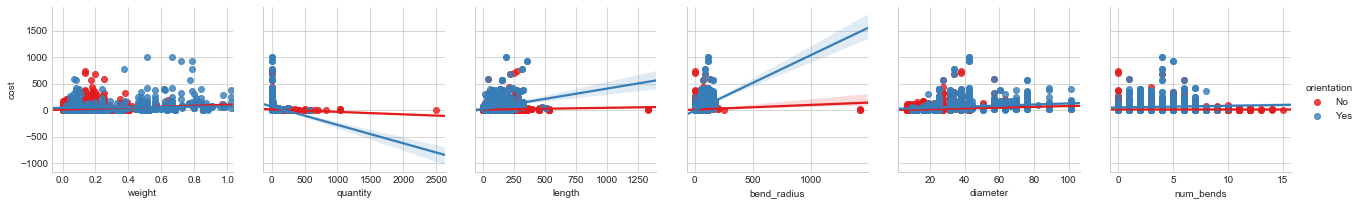

In [85]:
#Impact of input variables on Cost as a result of Orientation: 
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='orientation', size = 3, palette='Set1', kind= 'reg')

#### Observation
1. Oriented assemblies have higher cost decrease when purchased more
2. Longer length and higher bend radius oriented assemblies are more costly. 
3. Orientation has negligible impcat on assemblies weight and diameter. 

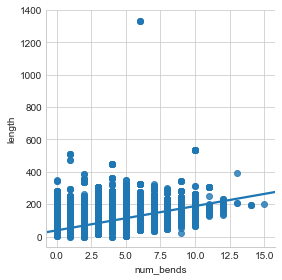

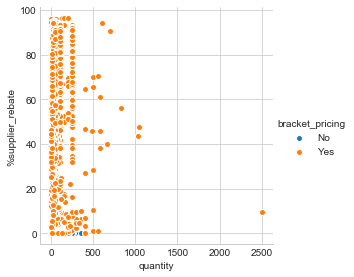

In [86]:
#Length Vs Number of Bends:
sns.pairplot(final_table, x_vars='num_bends', y_vars='length',size = 4, kind = 'reg')

#Supplier Rebate Vs Quantity: 
sns.pairplot(y_vars='%supplier_rebate', x_vars='quantity', data = final_table, hue = 'bracket_pricing', size = 4)

#### Observation: 
1. Longer length assemblies usaully have more bends.
2. No Supplier Rebate on min-order assemblies.

### Check for Multicolinearity: 

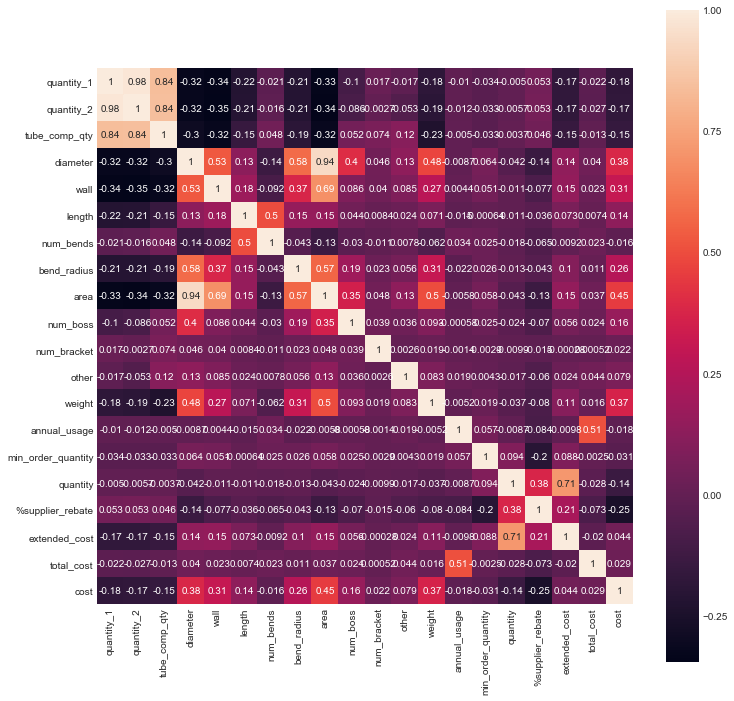

In [87]:
plt.figure(figsize=(12,12))
sns.heatmap(final_table.corr(), annot= True, square=True)

#### Observation: 
1. Columns which were used to build new fetures are multicolinear. Examples: Area, tube_comp_qty

#### Convert Categorical Lables Using Label Encoder:  

In [88]:
#Import Label Encoder:
from sklearn.preprocessing import LabelEncoder

#Initiate Label Encoder:
le = LabelEncoder()


In [89]:
#Drop Description Columns: 
final_table_dr= final_table.drop(['end_a', 'end_x', 'component_type_id', 'name', 'part_name'], axis = 1)

#Select Categorical Columns for label conversion 
print(final_table_dr.select_dtypes('category').columns)
col = final_table_dr[['supplier', 'bracket_pricing', 'component_id_1', 'component_id_2',
       'component_id_a', 'component_id_b','material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'forming_end_a', 'forming_end_x', 'orientation',
       'unique_feature']]

#Apply Label Encoder withjout dummy: 
final_table_label= col.astype(str).apply(le.fit_transform)

Index(['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id',
       'component_id_1', 'component_id_a', 'component_id_2', 'component_id_b',
       'end_a_1x', 'end_a_2x', 'forming_end_x', 'end_x_1x', 'end_x_2x',
       'forming_end_a', 'orientation', 'unique_feature'],
      dtype='object')


In [90]:
#View Converted Categorcal Labels: 
final_table_label.shape

(21095, 15)

In [91]:
#Remove original categorical columns to avoid duplication: 
final_table_dr=final_table_dr.drop(['supplier', 'bracket_pricing', 'component_id_1', 'component_id_2',
       'component_id_a', 'component_id_b','material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'forming_end_a', 'forming_end_x', 'orientation',
       'unique_feature'], axis =1)
final_table_dr.head()

,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,other,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,1,0.000000,29.559377,0.0,29.559377
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,2,40.122353,35.398919,0.0,17.699460
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,5,64.197647,52.914763,0.0,10.582953
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,10,72.225882,82.098563,0.0,8.209856
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,25,77.035294,169.705603,0.0,6.788224


In [92]:
model_a=pd.concat([final_table_dr, final_table_label], axis='columns')

In [93]:
model_a.head()

,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,component_id_b,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,forming_end_a,forming_end_x,orientation,unique_feature
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1


In [94]:
#Drop quote_date column:
model_a=model_a.drop(columns= ['quote_date'], axis =1)

In [95]:
#model_a=model_a.set_index(['tube_assembly_id', 'supplier'])

In [96]:
print(model_a.shape)
model_a.head()

(21095, 36)


,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,component_id_b,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,forming_end_a,forming_end_x,orientation,unique_feature
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1


#### Build Aggregated Table for Modelling:  

In [97]:
#Summary table grouped by tube assemblies:
model_agg=model_a.groupby(['tube_assembly_id', 'supplier', 'material_id']).agg({'component_id_1': lambda x: x.count(),
                                               'component_id_2': lambda x: x.count(), 
                                               'component_id_a': lambda x: x.count(), 
                                               'component_id_b': lambda x: x.count(),                                 
                                               'supplier': lambda x: x.count(),
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'supplier': lambda x : x.count(),
                                               'num_bends': lambda x : x.mean(),
                                               'diameter': lambda x: x.mean(),
                                               'wall': lambda x: x.mean(),
                                               'length': lambda x: x.mean(),                           
                                               'area': lambda x: x.mean(),
                                               #'extended_cost': lambda : x.mean(),
                                               'end_x_1x': lambda x : x.count(),
                                               'end_x_2x': lambda x : x.count(), 
                                               'forming_end_a': lambda x : x.count(), 
                                               'forming_end_x': lambda x : x.count(),
                                               'orientation': lambda x : x.count(),
                                               'unique_feature': lambda x : x.count(), 
                                               'bend_radius': lambda x : x.mean(), 
                                               'num_boss': lambda x: x.count(),
                                               'num_bracket': lambda x: x.count(),
                                               'other' : lambda x: x.count(),
                                               'weight': lambda x: x.mean(),
                                               'min_order_quantity' : lambda x: x.mean(),
                                               'quantity' : lambda x : x.mean(),                           
                                               #'bracket_pricing': lambda: x.count(),
                                               'tube_comp_qty': lambda x: x.mean(),                                 
                                               'material_id': lambda x: x.count(),                            
                                               'cost': lambda x: x.mean()})

In [98]:
model_agg=model_agg.dropna()

#### Fit, Predict & Assess Model: Linear Regression

In [99]:
#Import Linear Regression Library:
from sklearn.linear_model import LinearRegression

#Initiate Model:
lr = LinearRegression()

#Import Train Test Split Library:
from sklearn.model_selection import train_test_split 
X= model_a.drop(['tube_assembly_id','cost'], axis = 1)
y = model_a['cost']

#Normalize Values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_std = sc.fit_transform(X)
X = X_std

#Train Test Split Data:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [100]:
#View shape: 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16876, 34), (16876,), (4219, 34), (4219,))

In [101]:
#Fit model: 
model= lr.fit(X_train,y_train)

In [102]:
#Score Model:
model.score(X_train,y_train)

0.34755051826720507

In [103]:
#Print Model coefficients: 
print(lr.coef_, lr.intercept_)

[ -38.37876513   20.2284096    59.39842889 -277.81541443  -56.77896944
   36.06327406   -4.8327811    88.57402986  450.02567372    6.40942639
  -15.56655359  -14.39582752  136.38010606  -85.1508512   -76.63980963
  -84.49397351  -21.45191705   57.73209996   77.27674817  -11.81097004
   11.58197615    1.25109209   -3.51579269   -5.3102136    -1.80202819
   18.10576593   -4.48717372    2.08693895   -2.9977808     6.45102469
   -2.54301923   -8.88021897   14.36186097   -6.44203266] 23.700768871313258


In [104]:
#Run Prediction: 
y_pred=abs(lr.predict(X_test))

In [105]:
#View Model Prediction: 
result= pd.DataFrame(y_pred,y_test,columns=['predicted'])
result.head()

,predicted
cost,
17.348920,16.829637
2.982367,0.345883
6.768750,10.309252
17.418472,22.868044
2.762585,10.610613


In [106]:
#Print Model Metrics:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, accuracy_score
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_log_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 8.689291911820513
MSE: 0.5456744982069762
RMSE: 0.7386978395846141


#### Run Linear Regression Model on Aggregated Table: 

In [107]:
from sklearn.linear_model import LinearRegression
lr_agg = LinearRegression()

from sklearn.model_selection import train_test_split 
Xa= model_agg.drop('cost', axis = 1)
ya = model_agg['cost']
X_traina, X_testa, y_traina, y_testa = train_test_split(Xa,ya, test_size=0.20, random_state=12)

In [108]:
agg= lr_agg.fit(X_traina,y_traina)
agg.score(X_traina, y_traina)

0.27648729367923797

In [109]:
lr_agg.coef_, lr_agg.intercept_

(array([-5.52068485e-02, -5.52068485e-02, -5.52068485e-02, -5.52068485e-02,
        -5.52068485e-02, -3.14636935e-04,  2.12153693e-05,  1.03716225e-01,
        -1.29787098e-01, -2.03074371e+00, -1.78523840e+00,  5.33620092e-02,
         8.83532285e-02, -5.52068485e-02, -5.52068485e-02, -5.52068485e-02,
        -5.52068485e-02, -5.52068485e-02, -5.52068485e-02,  5.25367293e-02,
        -5.52068485e-02, -5.52068485e-02, -5.52068485e-02,  2.33688976e+01,
        -7.46098991e-02, -6.20881462e-02, -8.56602788e-01, -5.52068485e-02]),
 15.140862211781254)

In [110]:
y_pred_agg = abs(lr_agg.predict(X_testa))

In [111]:
pd.DataFrame(y_pred_agg, y_testa, columns= ['predict_agg']).head()

,predict_agg
cost,
2.929508,3.803466
14.322040,9.863051
18.217850,22.489436
1.680364,4.197760
13.062463,6.005435


In [112]:
#Import Metrices
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, accuracy_score
print('MAE:', mean_absolute_error(y_testa, y_pred_agg))
print('MSE:', mean_squared_log_error(y_testa,y_pred_agg))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testa, y_pred_agg)))

MAE: 7.755966731086788
MSE: 0.4695320533317854
RMSE: 0.6852240898653413


#### Observation: 
1. RMSE error on aggregated table is much lower, at 0.68

#### Fit, Predict & Assess Model: Decision Tree 

In [113]:
#Import Decision Tree Regressor:
from sklearn.tree import DecisionTreeRegressor

#Initiate Model:
dt = DecisionTreeRegressor()

#Fit Model
model_a_dt = dt.fit(X_train,y_train)

In [114]:
#Predict Model:
predict_dt = model_a_dt.predict(X_test)

In [115]:
#Score Model: 
score_dt= model_a_dt.score(X_test,y_test)

In [116]:
#Print Score: 
print('Model Score:',score_dt)

Model Score: 0.9917732862931062


In [117]:
#See Predicted Values:
predict_dt

array([17.34892028,  2.97402113,  6.76318557, ...,  5.39719457,
        4.18143476,  7.72299594])

In [118]:
#Convert predicted values to dataframe and compare with historical cost:
result_dt= pd.DataFrame(predict_dt, y_test, columns= ['predict_dt'])
result_dt.head()

,predict_dt
cost,
17.348920,17.348920
2.982367,2.974021
6.768750,6.763186
17.418472,17.415690
2.762585,2.798751


In [119]:
print('MAE:', mean_absolute_error(y_test, predict_dt))
print('MSE:', mean_squared_log_error(y_test,predict_dt))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, predict_dt)))

MAE: 0.40140127046027285
MSE: 0.007940496325695528
RMSE: 0.08910946260468373


#### Observation: 
1. RMSE error using Decision Forest Regressor significantly reduced to 0.10, accuracy 98%
2. Decision Tree is usually not preferred due to overfitting.

#### Fit, Predict & Assess Model: Random Forest

In [135]:
#Import Random forest Regressor:
from sklearn.ensemble import RandomForestRegressor

#Initiate Model:
rc = RandomForestRegressor()

#### Apply Grid Search CV to hyperparameter tune model: 

In [131]:
"""
#AVOID Re-Run Time Delay:

#Import GridsearchCV:
from sklearn.model_selection import GridSearchCV

#Initiate Grid Search and provide model parameters: ()
#param = {'criterion':['mse', 'mae'], 'bootstrap': [True, False], 'max_features': ['auto', 'sqrt']}
#gs = GridSearchCV(rc, param_grid=param, cv = 3, n_jobs=-1) 

# Fit model:
#model_a_rf = gs.fit(X_train, y_train)


#Best parameters selected after grid search: 
print('Model Best Parameters:', model_a_rf.best_params_)

"""


Model Best Parameters: {'bootstrap': False, 'criterion': 'mae', 'max_features': 'auto'}


##### Model Best Parameters: {'bootstrap': False, 'criterion': 'mae', 'max_features': 'auto'}

#### Fit hyperparameters:

In [136]:
#Input grid serach parameters to the model: 
#rc = RandomForestRegressor(bootstrap= False, criterion= 'mae', max_features= 'auto')

#Fit Model: 
#model_a_rf= rc.fit(X_train,y_train)

#Check Model Score:
score=model_a_rf.score(X_test,y_test)
print('Model Score:', score)

#Predict Supplier Cost:
predict_rf = model_a_rf.predict(X_test)

#Convert Result to Dataframe and view prediction:
df_predict_rf= pd.DataFrame(predict_rf, y_test, columns= ['predict_rf'])
print('\n''Model Price Prediction:' '\n', '\n',df_predict_rf.head())

#Print Model Metrics:
print('\n''MAE:', mean_absolute_error(y_test, predict_rf))
print('MSE:', mean_squared_log_error(y_test, predict_rf))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, predict_rf)))

Model Score: 0.9901212854759495

Model Price Prediction:
 
            predict_rf
cost                 
17.348920   17.350590
2.982367     2.981533
6.768750     6.727853
17.418472   17.415690
2.762585     2.794857

MAE: 0.3455576234612033
MSE: 0.00709361065519123
RMSE: 0.08422357541206162


#### Observation: 
1. Random Forest resulted in lowest RMSE error, at 0.08 and accuray 99%

#### Fit, Predict & Assess Model: PCA

In [137]:
#Import PCA Library
from sklearn.decomposition import PCA

#Initiate PCA model: 
pc = PCA(n_components=30)

# Fit and Transform Training Data: 
model_pca = pc.fit_transform(X_train)

#Transformed Values: 
model_pca

array([[ 1.30943665e+00, -6.26070106e-01, -5.92269239e-02, ...,
        -8.14701179e-04, -4.14532103e-03, -5.52499944e-03],
       [ 1.73295362e-01,  9.21577092e-01,  1.34228040e+00, ...,
         3.98155872e-03, -2.13838033e-03,  2.33475069e-02],
       [-3.66328282e-01,  5.82344175e-01,  2.19766543e-01, ...,
         1.45864784e-02, -1.66067705e-02,  1.58070573e-02],
       ...,
       [-3.01141555e-01,  1.23968814e+00,  5.75707600e-02, ...,
         2.17190062e-03, -3.14406020e-03,  5.24796591e-03],
       [-4.64186509e-01, -4.02873866e-01, -9.86465314e-02, ...,
        -1.24723585e-03,  1.78604436e-02,  3.48457885e-02],
       [-3.28509786e-01,  9.00713075e-01,  8.95718032e-01, ...,
         7.41464360e-03,  1.24871048e-02, -2.16173149e-03]])

[4.78065749e-01 1.82086459e-01 1.24765006e-01 7.49130553e-02
 5.77115506e-02 5.18335492e-02 4.64579300e-02 4.49916061e-02
 3.85894153e-02 3.16703364e-02 2.19618536e-02 1.90225866e-02
 1.78351545e-02 1.61501215e-02 1.27525059e-02 1.09779219e-02
 7.94014533e-03 6.60515098e-03 2.79419835e-03 2.51493039e-03
 1.70383904e-03 1.48339861e-03 1.41914192e-03 8.99167656e-04
 8.47690484e-04 5.61392000e-04 5.15355131e-04 3.73581059e-04
 2.66067020e-04 2.48514476e-04]
[3.79861765e-01 1.44682366e-01 9.91358521e-02 5.95244597e-02
 4.58564779e-02 4.11859321e-02 3.69145694e-02 3.57494569e-02
 3.06624004e-02 2.51646346e-02 1.74504625e-02 1.51149781e-02
 1.41714676e-02 1.28325731e-02 1.01328936e-02 8.72284365e-03
 6.30908536e-03 5.24832476e-03 2.22021577e-03 1.99831487e-03
 1.35383743e-03 1.17867974e-03 1.12762262e-03 7.14461166e-04
 6.73558405e-04 4.46071186e-04 4.09491183e-04 2.96840258e-04
 2.11411689e-04 1.97464779e-04]


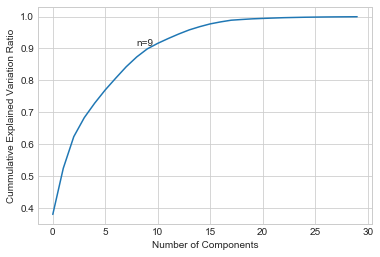

PCA Components Selected: 7 (This explains > 99% variance in the dataset)


In [138]:
#Identify expalined variance in data:
print(pc.explained_variance_)

#Identify exaplained variation ration in data:
print(pc.explained_variance_ratio_)

#Plot cummulative sum of explained ratio:
plt.plot(np.cumsum(pc.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variation Ratio')
plt.annotate('n=9', xy = (8,0.91))
plt.show()
#Select principle componenets that explains maximum variance:
print('PCA Components Selected:', 7 ,'(This explains > 99% variance in the dataset)')

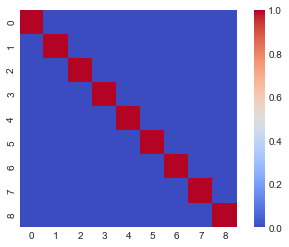

In [139]:
#Fit and trasnform model with selected components:
pca = PCA(n_components=9)
pca_train = pca.fit_transform(X_train)
pca_test = pca.fit_transform(X_test)

#Convert PCA training and test results in to dataframe: 
df_pca_train=pd.DataFrame(pca_train)
df_pca_test=pd.DataFrame(pca_test)

#Plot heatmap: 
sns.heatmap(df_pca_train.corr(), vmax=1, square=True, cmap='coolwarm')

### Use PCA train and test data to predict supplier cost using Linear Regression: 

In [140]:
#Fit model: 
model_pca_lr = lr.fit(pca_train, y_train)
print(model_pca_lr.coef_, model_pca_lr.intercept_)

[ 1.55647022 23.68519282 24.16528858  3.46460599 22.09572796 12.9189447
  6.94624013 20.73614512 -3.76181432] 14.295184404666514


In [141]:
#Predict Model: 
predict_pca_lr = abs(model_pca_lr.predict(pca_test))

In [142]:
#Convert result to dataframe: 
result_pca_lr= pd.DataFrame(predict_pca_lr, y_test, columns= ['predict_pca_lr'])

In [143]:
#View Predicted Results:
result_pca_lr.head()

,predict_pca_lr
cost,
17.348920,17.626312
2.982367,0.494035
6.768750,26.099006
17.418472,10.198956
2.762585,1.826765


In [144]:
#Print Metrics:
print('MAE:', mean_absolute_error(y_test, predict_pca_lr))
print('MSE:', mean_squared_log_error(y_test, predict_pca_lr))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, predict_pca_lr)))

MAE: 10.542696795987329
MSE: 0.7698252157370957
RMSE: 0.8773968405100943


#### Fit, Predict & Assess Model: Neural Network 

In [145]:
'''
#Import Neural Netwrok Library: 

import tensorflow as tf

tf.reset_default_graph

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#Initiate Model
model = Sequential()

#Add Layers:
model.add(Dense(200, input_dim = X.shape[1],name = 'layer_1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100, name = 'layer_2'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X,y, 
          #validation_data = (X_test, y_test), 
          validation_split= 0.20,
          batch_size = 20, 
          nb_epoch= 50)
'''
print('to be tried later')         

to be tried later


# Conclusion: 

1. Model 1: Supplier Pricing prediction: When compared Random Forest Regressor offered high accuracy > 98% and lowest RMSE error: 0.08

## Testing: Not to be implemented: 

In [146]:
final_table.head()

,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,unique_feature,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
150,TA-00052,S-0066,Yes,SP-0029,CP-018,C-1536,C-1536,2.0,C-1625,NaN,...,Yes,0.052,2013-10-01,0,0,1,0.000000,29.559377,0.0,29.559377
152,TA-00052,S-0066,Yes,SP-0029,CP-018,C-1536,C-1536,2.0,C-1625,NaN,...,Yes,0.052,2013-10-01,0,0,2,40.122353,35.398919,0.0,17.699460
154,TA-00052,S-0066,Yes,SP-0029,CP-018,C-1536,C-1536,2.0,C-1625,NaN,...,Yes,0.052,2013-10-01,0,0,5,64.197647,52.914763,0.0,10.582953
156,TA-00052,S-0066,Yes,SP-0029,CP-018,C-1536,C-1536,2.0,C-1625,NaN,...,Yes,0.052,2013-10-01,0,0,10,72.225882,82.098563,0.0,8.209856
158,TA-00052,S-0066,Yes,SP-0029,CP-018,C-1536,C-1536,2.0,C-1625,NaN,...,Yes,0.052,2013-10-01,0,0,25,77.035294,169.705603,0.0,6.788224


In [147]:
#df_dummy= pd.get_dummies(final_table, columns=['component_id'], drop_first=True)

#df_dummy.iloc[:, 39:].apply(lambda x: x.value_counts())

In [148]:
'''
#Get dummies for components:
df_dummy= pd.get_dummies(final_table['component_id'], drop_first=True)
comp_count=df_dummy.iloc[:,0:].apply(lambda x: x.sum())
#comp_count.reset_index(inplace=True)
df_comp_count=pd.DataFrame(comp_count, columns=['comp_counts'])
df_comp_count.rename_axis('component_id', inplace= True)
df_comp_count.reset_index().sort_values(by = 'comp_counts',ascending= False).head()
#df_comp_count=pd.melt(comp_count, value_name='comp_count', var_name='component_id')
#df_comp_count= df_comp_count.fillna(0)
#df_comp_count[df_comp_count.select_dtypes(['object']).columns]=df_comp_count.select_dtypes('object').apply(lambda x: x.astype('category'))
#df_comp_count.head()
'''

"\n#Get dummies for components:\ndf_dummy= pd.get_dummies(final_table['component_id'], drop_first=True)\ncomp_count=df_dummy.iloc[:,0:].apply(lambda x: x.sum())\n#comp_count.reset_index(inplace=True)\ndf_comp_count=pd.DataFrame(comp_count, columns=['comp_counts'])\ndf_comp_count.rename_axis('component_id', inplace= True)\ndf_comp_count.reset_index().sort_values(by = 'comp_counts',ascending= False).head()\n#df_comp_count=pd.melt(comp_count, value_name='comp_count', var_name='component_id')\n#df_comp_count= df_comp_count.fillna(0)\n#df_comp_count[df_comp_count.select_dtypes(['object']).columns]=df_comp_count.select_dtypes('object').apply(lambda x: x.astype('category'))\n#df_comp_count.head()\n"

In [149]:
#treat model_a column name: 
model_b=model_a.rename(columns= {'component_id': 'component_id_int'})

In [150]:
#model_a['component_id'].replace(columns=['component_id_int'])
#model_a.info()

In [151]:
'''
component_id=pd.DataFrame(final_table[['tube_assembly_id','component_id']])
component_id.head()
model_b=pd.merge(left= model_b, right= component_id, on = 'tube_assembly_id', how ='inner').drop('component_id_int', axis =1)
model_b = pd.merge(left = model_b, right= df_comp_count, on = 'component_id', how = 'inner')
#model_b.groupby('tube_assembly_id')['comp_count'].count()
model_b.head()
'''

"\ncomponent_id=pd.DataFrame(final_table[['tube_assembly_id','component_id']])\ncomponent_id.head()\nmodel_b=pd.merge(left= model_b, right= component_id, on = 'tube_assembly_id', how ='inner').drop('component_id_int', axis =1)\nmodel_b = pd.merge(left = model_b, right= df_comp_count, on = 'component_id', how = 'inner')\n#model_b.groupby('tube_assembly_id')['comp_count'].count()\nmodel_b.head()\n"

In [152]:
'''
#Let's run LR model: 
lr_b = LinearRegression()

#Import Train Test Split Library:
 
Xb= model_b.drop(['tube_assembly_id','cost', 'component_id'], axis = 1)
yb = model_b['cost']

#Normalize Values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Xb_std = sc.fit_transform(X)
Xb = X_std

#Train Test Split Data:
X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb,yb, test_size=0.20)

model_b = lr_b.fit(X_trainb, y_trainb)
print(model_b.coef_,model_b.intercept_)
predict_lrb = abs(model_b.predict(X_testb))

pd.DataFrame(predict_lrb, y_testb, columns=['predict_lrb']).head()

print('MAE:', mean_absolute_error(y_test, predict_lrb))
print('MSE:', mean_squared_log_error(y_test, predict_lrb))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, predict_lrb)))
'''

"\n#Let's run LR model: \nlr_b = LinearRegression()\n\n#Import Train Test Split Library:\n \nXb= model_b.drop(['tube_assembly_id','cost', 'component_id'], axis = 1)\nyb = model_b['cost']\n\n#Normalize Values\nfrom sklearn.preprocessing import MinMaxScaler\nsc = MinMaxScaler()\nXb_std = sc.fit_transform(X)\nXb = X_std\n\n#Train Test Split Data:\nX_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb,yb, test_size=0.20)\n\nmodel_b = lr_b.fit(X_trainb, y_trainb)\nprint(model_b.coef_,model_b.intercept_)\npredict_lrb = abs(model_b.predict(X_testb))\n\npd.DataFrame(predict_lrb, y_testb, columns=['predict_lrb']).head()\n\nprint('MAE:', mean_absolute_error(y_test, predict_lrb))\nprint('MSE:', mean_squared_log_error(y_test, predict_lrb))\nprint('RMSE:', np.sqrt(mean_squared_log_error(y_test, predict_lrb)))\n"

# 2. Build Pre-Classification Model to Categorize Spend: 

#### Using Primary table from section 1 to build category classification criteria: 

In [153]:
#View Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate,extended_cost,total_cost,area
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,0.000000,21.905933,0.0,74.92
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,43.662687,24.682428,0.0,74.92
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,69.862840,33.009131,0.0,74.92
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,78.600457,46.877695,0.0,74.92
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,83.832868,88.539030,0.0,74.92


In [154]:
#Import Datetime:
import datetime as dt

#Convert quote date from object to datetime format:
prime_77_final['quote_date']=pd.to_datetime(prime_77_final['quote_date'])

#### Create reference point in time to develop measurable features: 

In [155]:
# Creating reference point in time:
prime_77_final['quote_date'].max()
prime_77_final['quote_date'].min()
df_delta = prime_77_final['quote_date'].max()-prime_77_final['quote_date'].min()
print('Days of Transaction history:' '\n',df_delta)

#Day after most recent purchase:
now = prime_77_final['quote_date'].max() + dt.timedelta(1)
print('Reference Point:' '\n', now)

Days of Transaction history:
 12520 days 00:00:00
Reference Point:
 2017-01-02 00:00:00


#### Establish pre-classification criteria based on following business needs: 
1. Recency (R)
2. Usage (U)
3. Monetary Value (M)
4. Supplier Rebate(R), 
5. Market Difficulty (MD)

## Build Assembly and Supplier Segmentation:

#### a) Tube Assembly Segmentation: 
**Please note: As per data in the primary table, tube assemblies have a maximum of 2 unique suppliers supplying these assemblies, a result all assemblies would be classified as critical buy, making it difficult for us to explore other spend categories. Hence, instead of unique suppliers in the table below, I have used supplier count to build this model. This, should relate to more closely to a real business setting, where operations team would like to develop multiple sourcing options to ensure timely continuous supply.     

In [156]:
#Checking max ans min number of unique suppliers per each assembly:: 
test=prime_77_final.groupby(['tube_assembly_id']).agg({'supplier': lambda x : x.nunique()}) 
print(test.sort_values(by= 'supplier', ascending=False).head(2), '\n',test.sort_values(by= 'supplier', ascending=False).tail(2))

                  supplier
tube_assembly_id          
TA-04762                 2
TA-11013                 2 
                   supplier
tube_assembly_id          
TA-07477                 1
TA-21197                 1


In [157]:
#Group by Tube Assembly and obtain pre-classification values:
table=prime_77_final.groupby(['tube_assembly_id', 'supplier', 'bracket_pricing']).agg({'quote_date': lambda x: (now - x.max()).days,
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'supplier': lambda x : x.count()}) 

#Convert datatype to integer:
table['quote_date'] = table['quote_date'].astype(int)

#Round off total cost and supplier rebate:
table['total_cost'] =table['total_cost'].round(decimals= 2) 
table['%supplier_rebate'] =table['%supplier_rebate'].round(decimals= 2)

#Rename Column Names: 
table.rename(columns={'quote_date': 'recency', 
                      'annual_usage': 'frequency',
                      'total_cost': 'monetary_value',
                      'supplier': 'market_difficulty'}, inplace=True)
#View Table
table.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty
tube_assembly_id,supplier,bracket_pricing,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8
TA-00013,S-0026,No,8931,50,500.21,0.00,1


In [158]:
#Re-assign table to segmented: 
segmented = table

#### Build Classification Score and Assign Sourcing Portfolio Type: 

In [159]:
#Use 80/20 rule to split segmented data:  
quantiles = table.quantile(q=[0.20,0.80])

#View Table: 
quantiles

,recency,frequency,monetary_value,%supplier_rebate,market_difficulty
0.2,1219.0,0.0,0.000,0.00,1.0
0.8,2162.0,180.0,598.436,63.15,8.0


In [160]:
#Convert Quantile to Dictionary
quantiles = quantiles.to_dict()
quantiles

{'%supplier_rebate': {0.2: 0.0, 0.8: 63.15},
 'frequency': {0.2: 0.0, 0.8: 180.0},
 'market_difficulty': {0.2: 1.0, 0.8: 8.0},
 'monetary_value': {0.2: 0.0, 0.8: 598.436},
 'recency': {0.2: 1219.0, 0.8: 2162.0}}

#### Ideal Category Score  and Assignment Criteria:  
1. Lowest recency activity as 1.
2. Lowest market difficulty in switching suppliers as 1.
3. Highest frequently bought item as 1.
4. High Spend or profit impact on business as 1.
5. High supplier rebates as 1. 

In [161]:
#Write function: 
def RScore(result,column,value):
    
    """
    RScore will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 1, 2 & 3 respectively   
    """
    if result <= value[column][0.20]:
        return 1
    if (result> value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 3
    
def FMScore(result,column,value):
      
    """
    FMScore will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 3, 2 & 1 respectively   
    
    """
    if result <= value[column][0.20]:
        return 3
    if (result > value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 1


#### Apply Function to Segmented Table:

In [162]:
#Recency Score 
segmented['recency_score'] = segmented['recency'].apply(RScore, args=('recency',quantiles))

#Frequency Score:
segmented['frequency_score'] = segmented['frequency'].apply(FMScore, args=('frequency',quantiles))

#Spend Score:
segmented['monetary_score'] = segmented['monetary_value'].apply(FMScore, args=('monetary_value',quantiles))

#Rebate Score:
segmented['rebate_score'] = segmented['%supplier_rebate'].apply(FMScore, args=('%supplier_rebate',quantiles))

#Market Score:
segmented['market_score'] = segmented['market_difficulty'].apply(FMScore, args=('market_difficulty', quantiles))

In [163]:
#View Table: 
segmented.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3


In [164]:
#Combined Score: 
segmented['combined_score'] = (segmented['recency_score'].map(str) 
                               + segmented['frequency_score'].map(str) 
                               + segmented['monetary_score'].map(str)
                               + segmented['rebate_score'].map(str) 
                               + segmented['market_score'].map(str))

In [165]:
segmented.head(10)

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1,23311
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1,23311
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1,13311
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1,23311
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3,32233
TA-00014,S-0066,Yes,1387,0,0.00,66.41,8,2,3,3,1,1,23311
TA-00021,S-0030,No,1057,1,3.43,0.00,1,1,2,2,3,3,12233
TA-00022,S-0013,No,1986,1,8.56,0.00,1,2,2,2,3,3,22233
TA-00024,S-0066,Yes,1250,0,0.00,69.77,8,2,3,3,1,1,23311


In [166]:
#Top 10 Classification Scores 
segmented['combined_score'].sort_values(ascending= False).value_counts().head(10)

23311    1292
22233    1265
22222    1095
32233     805
21133     477
12233     387
13321     364
21233     338
13311     311
22133     273
Name: combined_score, dtype: int64

#### Assign Spend Categories:

In [167]:
#Write Function: 

def categorize(x):
    
    """
    Categorize will segment sourcing type based on combined score given in the table:
    
    Examples: 
    1) Critical Buy(buying often from only supplier)
    Type: High Frequency, Medium to High Spend, Low Rebates purchases bought from Sole Supplier
    
    2) Startegic Buy (buying high spend items from very few suppliers):
    Type: High Frequency, High Spend, High to Medium Rebates purchases bought from a Few Suppliers 
    
    3) Leverage Buy (buying frequently from many suppliers): 
    Type: Mostly Recent, High Frequency, Low Spend, High Rebates purchases bought from Many Suppliers
    
    4) Spot Buy (not buying often and can buy from anyone)
    Type: Low Frequency, Low Rebate Purchases bought from Any Supplier
    
    5) Unclassified spend
    
    """
    
    #High Frequency Sole Suppliers                                 or               Low Rebate Sole Suppliers:
    if (x['combined_score'][1]=='1')& (x['combined_score'][4]=='3') | (x['combined_score'][3]=='3')& (x['combined_score'][4]=='3'):
        return ('Critical Buy')
    
    #High Spend Few Suppliers                                          or          High Rebate Few Suppliers                          or        Medium Rebate Few Suppliers                           or        High Frequency Few Suppliers
    elif (x['combined_score'][2]=='1') & (x['combined_score'][4]=='2') | (x['combined_score'][3]=='1') & (x['combined_score'][4]=='2') | (x['combined_score'][3]=='2') & (x['combined_score'][4]=='2') | (x['combined_score'][1]=='1') & (x['combined_score'][4]=='2'):
        return ('Strategic Buy')
    #High Frequency Many Suppliers                                    or         Low Spend Many Suppliers                            or         High Rebate Multiple Suppliers                       or         Recent Buy Multiple Suppliers
    elif (x['combined_score'][1]=='1') & (x['combined_score'][4]=='1') | (x['combined_score'][2]=='3') & (x['combined_score'][4]=='1')| (x['combined_score'][3]=='1') & (x['combined_score'][4]=='1') | (x['combined_score'][0]=='1') & (x['combined_score'][4]=='1'):
        return ('Leverage Buy')
    
    # Low Frequency Medium Rebate High Value Clients:
    elif (x['combined_score'][1]=='2') & (x['combined_score'][3]=='2'):
        return ('Spot Buy')
    
    else:
        return('Unclassified Buy')
    
       

In [168]:
segmented['category_type'] = segmented.apply(categorize, axis =1)

In [169]:
segmented.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1,23311,Leverage Buy
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1,23311,Leverage Buy
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1,13311,Leverage Buy
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1,23311,Leverage Buy
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3,32233,Critical Buy


In [170]:
segmented.groupby([segmented['category_type']=='Spot Buy']).nunique()

,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
category_type,,,,,,,,,,,,
False,1738,848,5669,2615,9,3,3,3,3,3,74,4
True,17,13,19,19,1,3,1,2,1,1,5,1


In [171]:
segmented[segmented['category_type']=='Unclassified Buy'].head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00434,S-0066,Yes,1981,164,501.88,65.56,1,2,2,2,1,3,22213,Unclassified Buy
TA-00969,S-0072,Yes,1196,50,334.26,0.00,2,1,2,2,3,2,12232,Unclassified Buy
TA-01270,S-0041,Yes,1103,2,0.23,0.00,2,1,2,2,3,2,12232,Unclassified Buy
TA-01460,S-0062,Yes,888,28,51.47,0.00,2,1,2,2,3,2,12232,Unclassified Buy
TA-01597,S-0013,Yes,1414,25,36.61,66.03,1,2,2,2,1,3,22213,Unclassified Buy


#### Visualize Sourcing Classification:

Text(0.5,1,'Category Segmentation')

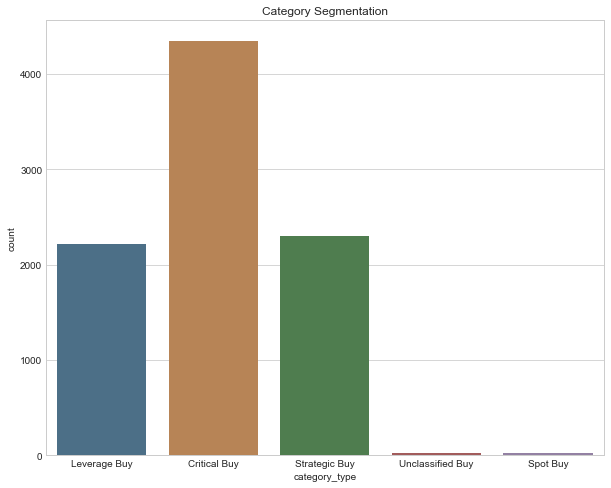

In [172]:
#Count plot to see Sourcing breakdown based on assigned category scores:
plt.figure(figsize=(10,8))
sns.set_style(style='whitegrid')
sns.countplot(x= 'category_type', data = segmented, saturation=0.4)
plt.title('Category Segmentation')

In [173]:
#Calculate % of each source type:
a= segmented['category_type'].value_counts()
b= segmented['category_type'].count()
c=a/b
print(c)

Critical Buy        0.487652
Strategic Buy       0.258756
Leverage Buy        0.248428
Unclassified Buy    0.003031
Spot Buy            0.002133
Name: category_type, dtype: float64


In [174]:
c.index

Index(['Critical Buy', 'Strategic Buy', 'Leverage Buy', 'Unclassified Buy',
       'Spot Buy'],
      dtype='object')

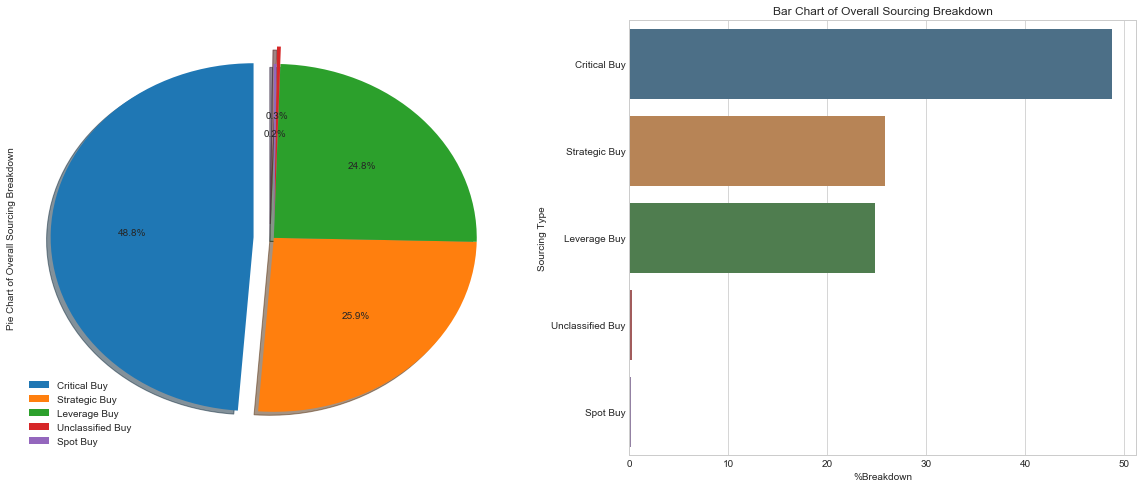

In [175]:
#Plot pie and bar chart to see %breakdown of each sourcing type: 
plt.figure(figsize = (20,8))
plt.subplot(1,2,2)
sns.barplot(y = c.index, x = c * 100, saturation=0.4, label= 'Spend Breakdown')
plt.xlabel('%Breakdown')
plt.ylabel('Sourcing Type')
plt.title('Bar Chart of Overall Sourcing Breakdown')

plt.subplot(1,2,1)
c.plot(kind= 'pie', label='Pie Chart of Overall Sourcing Breakdown', explode= (0.1, 0, 0, 0.1,0), autopct='%1.1f%%', shadow=True, startangle=90, labels =None)
plt.legend(c.index,loc='lower left')

### Observation: 
1. Majority of tube assemblies are purchased from sole suppliers, 48.6%
2. Leverage and Startegic Options account 25% to 26.2% each. 
3. There may be opportities to consolodate critical spend with leverage or strategic suppliers. 

## Prepare segmented table for K-Means Clustering: 

#### Check for skewness in data and normalize: 

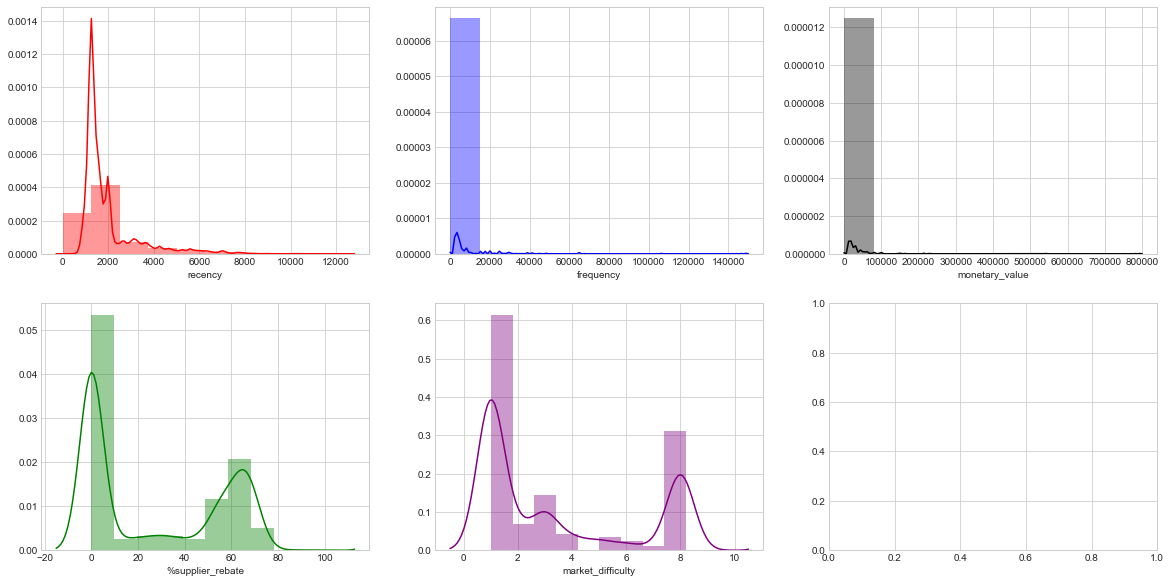

In [176]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(segmented['recency'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(segmented['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(segmented['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(segmented['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(segmented['market_difficulty'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. Distribution is highly skewed. We would need to make these distribution normal in order to make meaningful clusters. 

#### Log Transformation: 

In [177]:
segmented_log = np.log(segmented[['recency', 'frequency', 'monetary_value', '%supplier_rebate', 'market_difficulty']]+1)

In [178]:
segmented_log.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty
tube_assembly_id,supplier,bracket_pricing,,,,,
TA-00002,S-0066,Yes,7.151485,0.000000,0.000000,4.214791,2.197225
TA-00004,S-0066,Yes,7.151485,0.000000,0.000000,4.211831,2.197225
TA-00005,S-0066,Yes,7.106606,0.000000,0.000000,4.172385,2.197225
TA-00012,S-0066,Yes,7.123673,0.000000,0.000000,4.192076,2.197225
TA-00013,S-0026,No,9.097396,3.931826,6.217025,0.000000,0.693147


#### Standardise segmented_log table to ensure common scale: 


In [179]:
#Import Standard Scaler:
from sklearn.preprocessing import StandardScaler

#Initiate Standard Scaler
s= StandardScaler()

#Fit and Transform Segmented_log table:
segmented_log_normalized= s.fit_transform(segmented_log)

#Convert to dataframe:
df_segmented_log_normalized= pd.DataFrame(segmented_log_normalized, index=segmented_log.index, columns = segmented_log.columns)

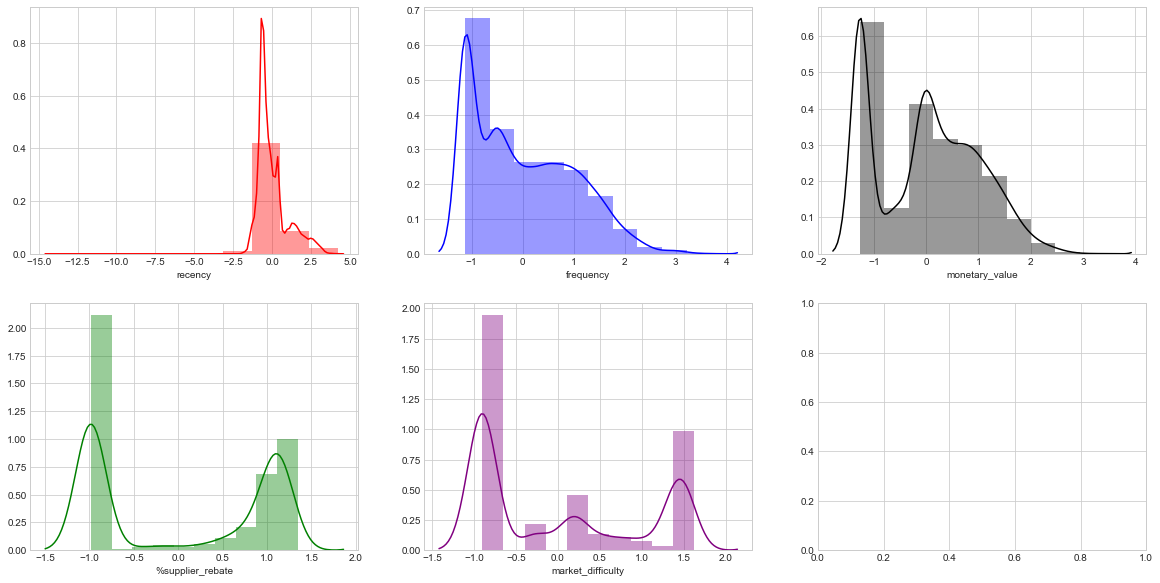

In [180]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(df_segmented_log_normalized['recency'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(df_segmented_log_normalized['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(df_segmented_log_normalized['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(df_segmented_log_normalized['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(df_segmented_log_normalized['market_difficulty'], bins = 10, ax = axes[1,1], color='purple')

## Fit Model: K-Means Clustering

#### Find optimal number of clusters using Elbow Method: 

In [181]:
#Import K-Means model: 
from sklearn.cluster import KMeans

#Create empty dictionary of Sum of squared error (sse)
sse = {}

# iterate values of k clusters from 1 to 30: 
for k in range(1,30):
    
    #Initiate Kmeans
    k_m = KMeans(n_clusters=k)
    
    #Fit model:
    k_m.fit(df_segmented_log_normalized)
    
    #Calculate sse for each value of k
    sse[k] = k_m.inertia_  
    

In [182]:
print('SSE Key Value-Pairs:' '\n',sse.keys(), sse.values())

SSE Key Value-Pairs:
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]) dict_values([44539.99999999999, 21918.08940244162, 17370.186847927427, 13784.48450141421, 10325.897101975246, 9141.256852223878, 8084.9004280152685, 7156.240697727631, 6513.408856013338, 6095.973871006728, 5714.394230618244, 5370.742365920389, 5039.226933097884, 4715.098135941186, 4524.268591778384, 4314.341837679885, 4117.770083887046, 3954.9914838319855, 3773.380294970889, 3654.2081132368367, 3512.987022899461, 3372.8020075752934, 3263.4614867883724, 3135.097439993491, 3035.6283511281217, 2993.0096254986024, 2893.086605580697, 2786.606452952818, 2709.2770857468886])


Text(5,11000,'K=5')

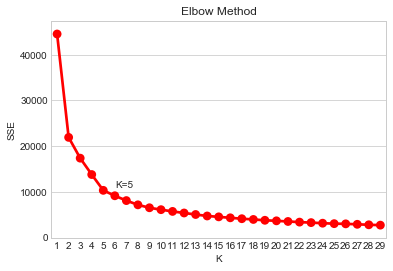

In [183]:
sns.pointplot(x=list(sse.keys()), y = list(sse.values()), color='red')

plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.annotate('K=5', xy =(5,11000))

#### Apply K-Means Model: 

In [184]:
#initiatlize kmeans with optimal clusters:
k_m = KMeans(n_clusters=5, random_state=12)

#Fit model:

k_m.fit(df_segmented_log_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=12, tol=0.0001, verbose=0)

In [185]:
#Generate Cluster labels: 
clusters=k_m.labels_

#Assign cluster labels to segmented table: 
segmented_cluster = segmented_log.assign(cluster_labels=clusters)

In [186]:
#View Table: 
segmented_cluster.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,cluster_labels
tube_assembly_id,supplier,bracket_pricing,,,,,,
TA-00002,S-0066,Yes,7.151485,0.000000,0.000000,4.214791,2.197225,0
TA-00004,S-0066,Yes,7.151485,0.000000,0.000000,4.211831,2.197225,0
TA-00005,S-0066,Yes,7.106606,0.000000,0.000000,4.172385,2.197225,0
TA-00012,S-0066,Yes,7.123673,0.000000,0.000000,4.192076,2.197225,0
TA-00013,S-0026,No,9.097396,3.931826,6.217025,0.000000,0.693147,2


#### Build Aggregated Table for the Clusters: 

In [187]:
segmented_agg=segmented_cluster.groupby('cluster_labels').agg({'recency': 'mean',
                                                              'frequency': 'mean',
                                                              'monetary_value': ['mean', 'count'], 
                                                              '%supplier_rebate': ['mean', 'count'],
                                                              'market_difficulty': ['mean', 'count']}).round(decimals= 0) 

In [188]:
#View Table: 
segmented_agg#=segmented_agg.reset_index()

recency frequency monetary_value       %supplier_rebate        \
                  mean      mean           mean count             mean count   
cluster_labels                                                                 
0                  7.0       0.0            0.0  2141              4.0  2141   
1                  7.0       6.0            7.0  2314              0.0  2314   
2                  8.0       3.0            5.0  1184              0.0  1184   
3                  7.0       3.0            4.0  1896              4.0  1896   
4                  7.0       2.0            3.0  1373              0.0  1373   

               market_difficulty        
                            mean count  
cluster_labels                          
0                            2.0  2141  
1                            1.0  2314  
2                            1.0  1184  
3                            2.0  1896  
4                            1.0  1373

In [189]:
segmented_melt= pd.melt(segmented_cluster.reset_index(), 
                        id_vars=['tube_assembly_id','supplier', 'bracket_pricing','cluster_labels'],
                        value_vars=['recency','frequency', 'monetary_value', '%supplier_rebate', 'market_difficulty'],
                        var_name='criteria',
                        value_name='normalized_value')

In [190]:
segmented_melt.head()

,tube_assembly_id,supplier,bracket_pricing,cluster_labels,criteria,normalized_value
0,TA-00002,S-0066,Yes,0,recency,7.151485
1,TA-00004,S-0066,Yes,0,recency,7.151485
2,TA-00005,S-0066,Yes,0,recency,7.106606
3,TA-00012,S-0066,Yes,0,recency,7.123673
4,TA-00013,S-0026,No,2,recency,9.097396


In [191]:
segmented_melt=segmented_melt.set_index(['tube_assembly_id'])

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

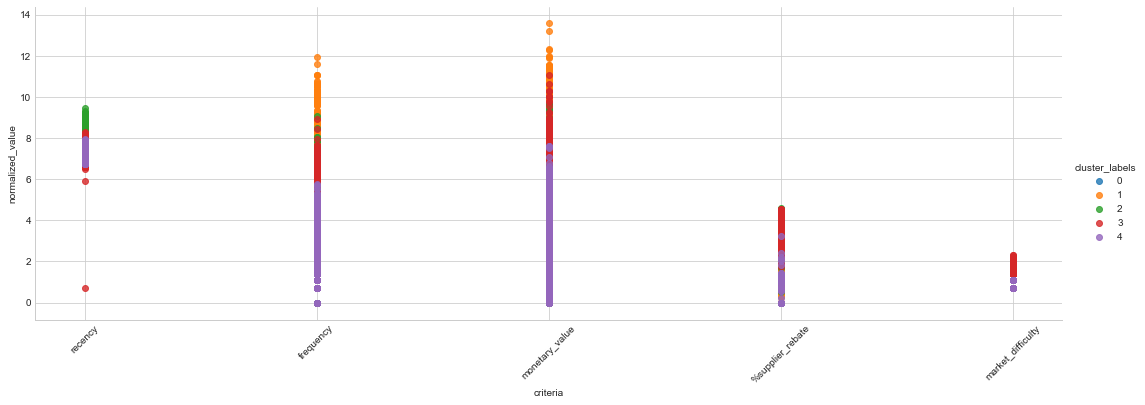

In [192]:
#plt.figure(figsize= (10,10))
sns.lmplot(x= 'criteria', y = 'normalized_value', data= segmented_melt, fit_reg=False, hue='cluster_labels', size = 5, aspect=3)
plt.xticks(rotation= 45)

Text(121.875,0.5,'Normalized Value')

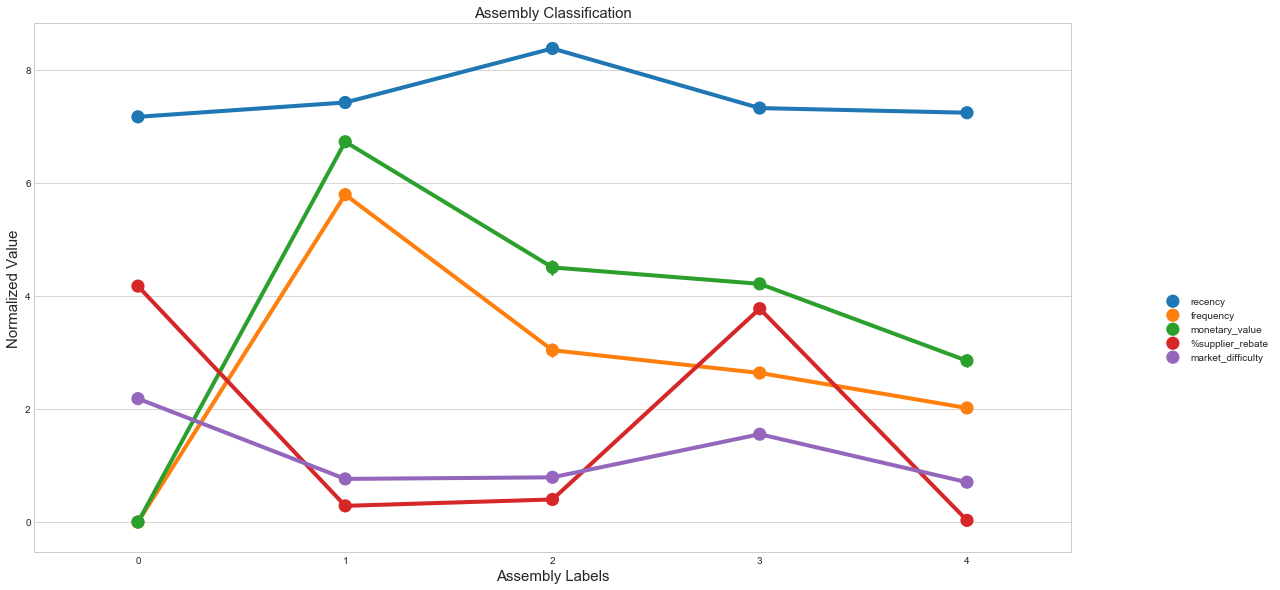

In [231]:
plt.figure(figsize= (15,8))
sns.pointplot(x= 'cluster_labels', y = 'normalized_value', data= segmented_melt, hue='criteria', scale = 1.5, fontsize=2)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(1.2, 0.5))
plt.title('Assembly Classification', fontsize=15)
plt.xlabel('Assembly Labels', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)

#### Observation: 
1. Assembly labels 1,2 and 4 have high supplier spend but lowest supplier rebate.
2. Assembly label 0 suppliers are motivated to develop business,hence offering great rebates without visibility in spend.
3. Assembly label 3 is by far the best managed category spend. Getting good rebate from fewer suppliers.  

In [194]:
segmented_melt[segmented_melt['cluster_labels']==4].head()

,supplier,bracket_pricing,cluster_labels,criteria,normalized_value
tube_assembly_id,,,,,
TA-00021,S-0030,No,4,recency,6.964136
TA-00022,S-0013,No,4,recency,7.594381
TA-00062,S-0041,No,4,recency,6.851185
TA-00063,S-0041,No,4,recency,6.851185
TA-00064,S-0041,No,4,recency,6.851185


#### b) Build Supplier Segmentation:

In [195]:
#Group by Tube Assembly and obtain pre-classification values:
table_2=prime_77_final.groupby(['supplier']).agg({'quote_date': lambda x: (now - x.max()).days/365,
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'tube_assembly_id': lambda x : x.count()}) 

#Convert datatype to integer:
table_2['quote_date'] = table_2['quote_date'].astype(int)

#Round off total cost and supplier rebate:
table_2['total_cost'] =table_2['total_cost'].round(decimals= 2) 
table_2['%supplier_rebate'] =table_2['%supplier_rebate'].round(decimals= 2)

#Rename Column Names: 
table_2.rename(columns={'quote_date': 'contract_length_yrs', 
                      'annual_usage': 'frequency',
                      'total_cost': 'monetary_value',
                      'tube_assembly_id': 'supplier_preference'}, inplace=True)
#View Table
table_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
supplier,,,,,
S-0003,4,4,385.07,0.0,1
S-0004,3,1,11.89,0.0,1
S-0005,2,8936,47097.69,0.0,24
S-0006,3,300,7741.08,0.0,1
S-0007,5,1551,66080.08,0.0,5


In [196]:
#Re-assign table to segmented: 
segmented_2 = table_2

#### Build Classification Score and Assign Sourcing Portfolio Type: 

In [197]:
#Use 80/20 rule to split segmented data:  
quantiles_2 = table_2.quantile(q=[0.20,0.80])

#View Table: 
quantiles_2

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
0.2,2.0,7.4,44.798,0.00,1.0
0.8,4.0,18033.8,135121.114,26.19,84.8


In [198]:
#Convert Quantile to Dictionary
quantiles_2 = quantiles_2.to_dict()
quantiles_2

{'%supplier_rebate': {0.2: 0.0, 0.8: 26.190000000000005},
 'contract_length_yrs': {0.2: 2.0, 0.8: 4.0},
 'frequency': {0.2: 7.400000000000002, 0.8: 18033.800000000003},
 'monetary_value': {0.2: 44.798, 0.8: 135121.11400000018},
 'supplier_preference': {0.2: 1.0, 0.8: 84.80000000000011}}

#### Ideal Category Score  and Assignment Criteria:  
1. Longest contract length in years  is rated as 1.
2. Supplier carrying maximum assortment of assemblies is rated as 1.
3. Highest frequently bought item is rated as 1.
4. High Spend or profit impact on business is rated as 1.
5. High supplier rebates is rated as 1. 

#### Apply Function RScore and FMScore to new Segmented Table:

In [199]:
#Recency Score 
segmented_2['relationship_score'] = segmented_2['contract_length_yrs'].apply(FMScore, args=('contract_length_yrs',quantiles_2))

#Frequency Score:
segmented_2['frequency_score'] = segmented_2['frequency'].apply(FMScore, args=('frequency',quantiles_2))

#Spend Score:
segmented_2['monetary_score'] = segmented_2['monetary_value'].apply(FMScore, args=('monetary_value',quantiles_2))

#Rebate Score:
segmented_2['rebate_score'] = segmented_2['%supplier_rebate'].apply(FMScore, args=('%supplier_rebate',quantiles_2))

#Market Score:
segmented_2['preference_score'] = segmented_2['supplier_preference'].apply(FMScore, args=('supplier_preference', quantiles_2))

In [200]:
#View Table: 
segmented_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score
supplier,,,,,,,,,,
S-0003,4,4,385.07,0.0,1,1,3,2,3,3
S-0004,3,1,11.89,0.0,1,2,3,3,3,3
S-0005,2,8936,47097.69,0.0,24,3,2,2,3,2
S-0006,3,300,7741.08,0.0,1,2,2,2,3,3
S-0007,5,1551,66080.08,0.0,5,1,2,2,3,2


In [201]:
#Combined Score: 
segmented_2['combined_score'] = (segmented_2['relationship_score'].map(str) 
                               + segmented_2['frequency_score'].map(str) 
                               + segmented_2['monetary_score'].map(str)
                               + segmented_2['rebate_score'].map(str) 
                               + segmented_2['preference_score'].map(str))

In [202]:
segmented_2.head(10)

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score
supplier,,,,,,,,,,,
S-0003,4,4,385.07,0.00,1,1,3,2,3,3,13233
S-0004,3,1,11.89,0.00,1,2,3,3,3,3,23333
S-0005,2,8936,47097.69,0.00,24,3,2,2,3,2,32232
S-0006,3,300,7741.08,0.00,1,2,2,2,3,3,22233
S-0007,5,1551,66080.08,0.00,5,1,2,2,3,2,12232
S-0008,3,7,70.49,52.71,7,2,3,2,1,2,23212
S-0009,2,4,269.37,0.00,4,3,3,2,3,2,33232
S-0011,2,215,787.85,0.00,5,3,2,2,3,2,32232
S-0012,5,438,2535.39,0.00,1,1,2,2,3,3,12233


In [203]:
#Top 10 Classification Scores 
segmented_2['combined_score'].sort_values(ascending= False).value_counts().head(10)

32222    6
31121    6
32232    5
31111    4
32233    3
12232    3
13332    3
22212    2
33232    2
22233    2
Name: combined_score, dtype: int64

#### Assign Supplier Categories: To be revised

In [204]:
#Write Function: 

def categorize_2(x):
    
    """
    Categorize_2 will segment supplier types based on combined score given in the table:
    
    Examples: 
    1) Sole Supplier Buy(buying often from only supplier)
    Type: Relationship based, Low Rebate supplier providing single type of assembly 
    
    2) Preferred Supplier (buying high spend items from very few suppliers):
    Type: High Frequency, High Spend, High to Medium Rebates purchases bought from a Few Preferred Suppliers. 
    
    3) Tactical Suppliers (buying frequently from many suppliers): 
    Type: Mostly Recent, High Frequency, Low Spend, High Rebates purchases bought from Many Suppliers.
       
    4) Unclassified Suppliers
    
    """
    
    #Long Term Relationship Low Rebate Supplier                          or               Low Rebate Single Assortment Supplier:
    if (x['combined_score'][0]=='1') & (x['combined_score'][3]=='3') | (x['combined_score'][3]=='3') & (x['combined_score'][4]=='3'):
        return ('Sole Supplier')
    
    #Long Term Relationship High Assortment Supplier                       or     High Spend High Rebate Supplier                             or        High Frequency High Spend Suppliers                  or       Long Term Relationship Medium Assortment Supplier
    elif (x['combined_score'][0]=='1') & (x['combined_score'][4]=='1') | (x['combined_score'][2]=='1') & (x['combined_score'][3]=='1')  | (x['combined_score'][1]=='1') & (x['combined_score'][2]=='1') | (x['combined_score'][0]=='1') & (x['combined_score'][4]=='2') :
        return ('Preferred Supplier')
    
    #Medium Relationship Medium Spend Supplier                      or              Medium Frequency Medium Assortment Supplier         or         Medium Rebate Medium Assortment Supplier            
    elif (x['combined_score'][0]=='2') & (x['combined_score'][2]=='2') | (x['combined_score'][1]=='2') & (x['combined_score'][4]=='2')| (x['combined_score'][3]=='2') & (x['combined_score'][4]=='2') :
        return ('Tactical Supplier')

    else:
        return('Unclassified Supplier')
    
       

In [205]:
segmented_2['supplier_type'] = segmented_2.apply(categorize_2, axis =1)

In [206]:
segmented_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0003,4,4,385.07,0.0,1,1,3,2,3,3,13233,Sole Supplier
S-0004,3,1,11.89,0.0,1,2,3,3,3,3,23333,Sole Supplier
S-0005,2,8936,47097.69,0.0,24,3,2,2,3,2,32232,Tactical Supplier
S-0006,3,300,7741.08,0.0,1,2,2,2,3,3,22233,Sole Supplier
S-0007,5,1551,66080.08,0.0,5,1,2,2,3,2,12232,Sole Supplier


In [207]:
segmented_2[segmented_2['supplier_type']=='Unclassified Supplier'].head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0009,2,4,269.37,0.00,4,3,3,2,3,2,33232,Unclassified Supplier
S-0054,2,3483,16269.33,42.24,838,3,2,2,1,1,32211,Unclassified Supplier
S-0104,2,10852,143507.83,0.00,90,3,2,1,3,1,32131,Unclassified Supplier
S-0107,2,2,48.09,0.00,2,3,3,2,3,2,33232,Unclassified Supplier


#### Visualize Sourcing Classification:

Text(0.5,1,'Supplier Segmentation')

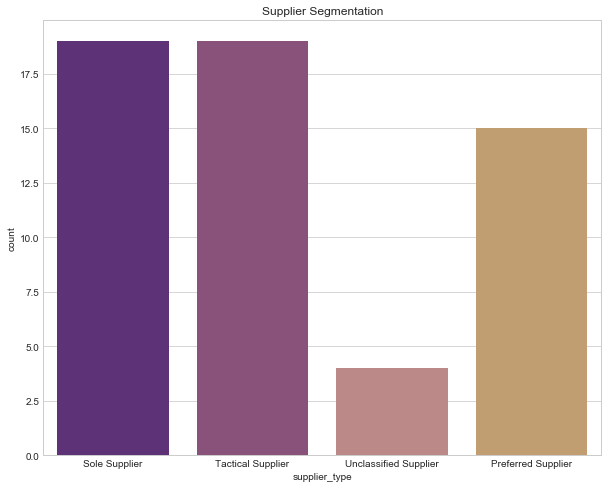

In [208]:
#Count plot to see Sourcing breakdown based on assigned category scores:
plt.figure(figsize=(10,8))
sns.set_style(style='whitegrid')
sns.countplot(x= 'supplier_type', data = segmented_2, saturation=0.4, palette='plasma')
plt.title('Supplier Segmentation')

In [209]:
#Calculate % of each source type:
a_2= segmented_2['supplier_type'].value_counts()
b_2= segmented_2['supplier_type'].count()
d=a_2/b_2
print(d)

Tactical Supplier        0.333333
Sole Supplier            0.333333
Preferred Supplier       0.263158
Unclassified Supplier    0.070175
Name: supplier_type, dtype: float64


In [210]:
d.index

Index(['Tactical Supplier', 'Sole Supplier', 'Preferred Supplier',
       'Unclassified Supplier'],
      dtype='object')

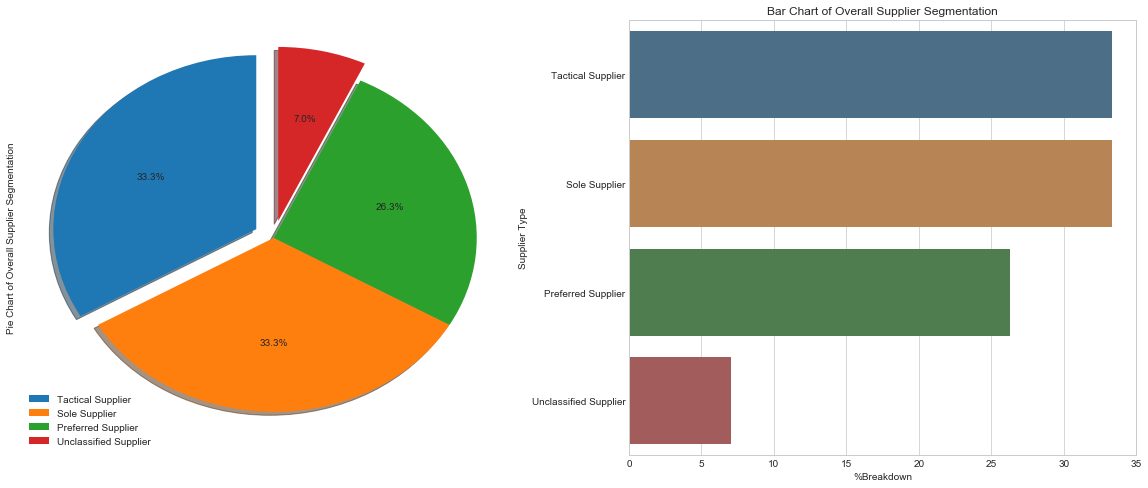

In [211]:
#Plot pie and bar chart to see %breakdown of each sourcing type: 
plt.figure(figsize = (20,8))
plt.subplot(1,2,2)
sns.barplot(y = d.index, x = d * 100, saturation=0.4, label= 'Spend Breakdown')
plt.xlabel('%Breakdown')
plt.ylabel('Supplier Type')
plt.title('Bar Chart of Overall Supplier Segmentation')

plt.subplot(1,2,1)
d.plot(kind= 'pie', label='Pie Chart of Overall Supplier Segmentation', explode= (0.1, 0, 0, 0.1), autopct='%1.1f%%', shadow=True, startangle=90, labels =None)
plt.legend(d.index,loc='lower left')

### Observation: 
1. High number of Sole and Tactical Suppliers, 33.3%
2. Preferred suppliers, 26.3%. 
3. There may be opportunities to transform unclassified suppliers into Preferred or Tactical.   

## Prepare segmented table for K-Means Clustering: 

#### Check for skewness in data and normalize: 

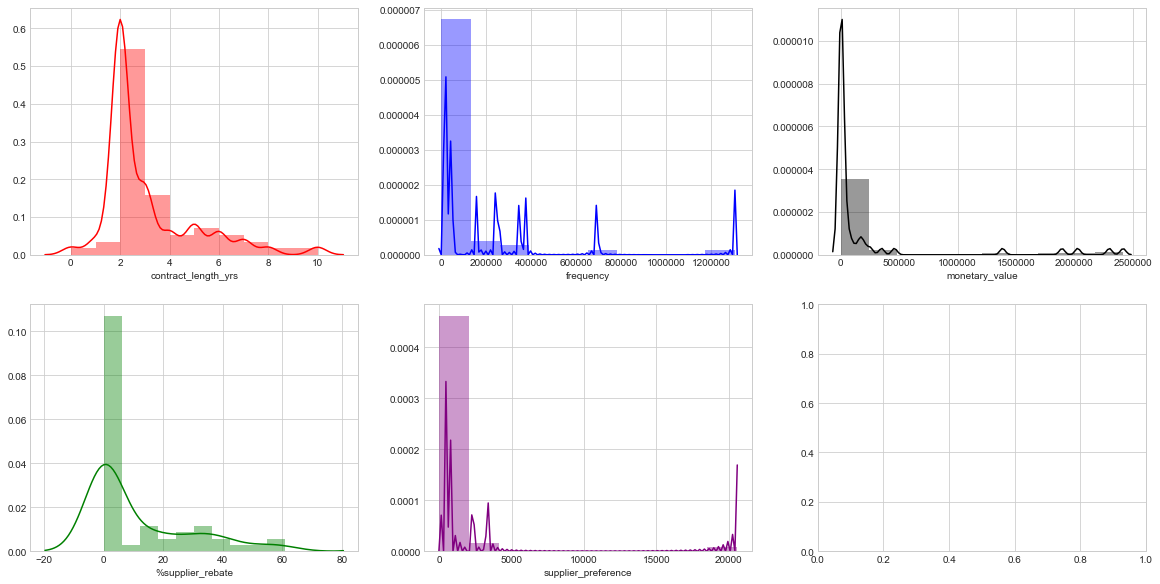

In [212]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(segmented_2['contract_length_yrs'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(segmented_2['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(segmented_2['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(segmented_2['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(segmented_2['supplier_preference'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. Distribution is highly skewed. We would need to make these distribution normal in order to make meaningful clusters. 

#### Log Transformation: 

In [213]:
segmented_2_log = np.log(segmented_2[['contract_length_yrs', 'frequency', 'monetary_value', '%supplier_rebate', 'supplier_preference']]+1)

In [214]:
segmented_2_log.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
supplier,,,,,
S-0003,1.609438,1.609438,5.956019,0.0,0.693147
S-0004,1.386294,0.693147,2.556452,0.0,0.693147
S-0005,1.098612,9.097955,10.760000,0.0,3.218876
S-0006,1.386294,5.707110,8.954426,0.0,0.693147
S-0007,1.791759,7.347300,11.098638,0.0,1.791759


#### Standardise segmented_log table to ensure common scale: 


In [215]:
#Import Standard Scaler:
from sklearn.preprocessing import StandardScaler

#Initiate Standard Scaler
s_2= StandardScaler()

#Fit and Transform Segmented_log table:
segmented_2_log_normalized= s_2.fit_transform(segmented_2_log)

#Convert to dataframe:
df_segmented_2_log_normalized= pd.DataFrame(segmented_2_log_normalized, index=segmented_2_log.index, columns = segmented_2_log.columns)

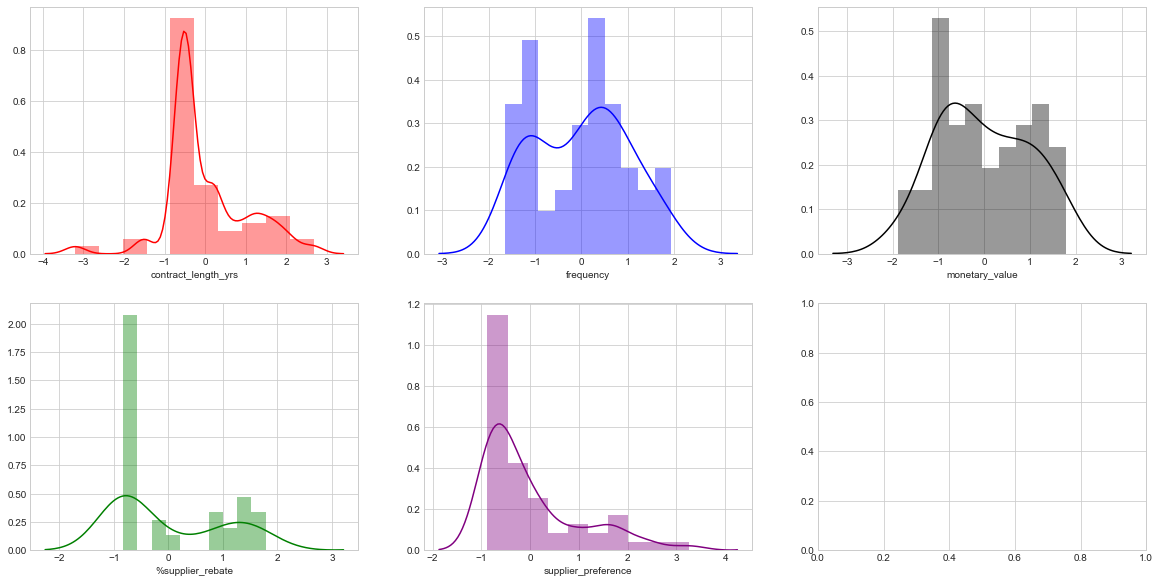

In [216]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(df_segmented_2_log_normalized['contract_length_yrs'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(df_segmented_2_log_normalized['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(df_segmented_2_log_normalized['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(df_segmented_2_log_normalized['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(df_segmented_2_log_normalized['supplier_preference'], bins = 10, ax = axes[1,1], color='purple')

## Fit Model: K-Means Clustering

#### Find optimal number of clusters using Elbow Method: 

In [217]:
#Import K-Means model: 
from sklearn.cluster import KMeans

#Create empty dictionary of Sum of squared error (sse)
sse_2 = {}

# iterate values of k clusters from 1 to 30: 
for k in range(1,30):
    
    #Initiate Kmeans
    k_m_2 = KMeans(n_clusters=k)
    
    #Fit model:
    k_m_2.fit(df_segmented_2_log_normalized)
    
    #Calculate sse for each value of k
    sse_2[k] = k_m_2.inertia_  
    

In [218]:
print('SSE Key Value-Pairs:' '\n',sse_2.keys(), sse_2.values())

SSE Key Value-Pairs:
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]) dict_values([285.00000000000006, 153.42949771958632, 116.70315254503885, 87.72430251573638, 69.26308099975108, 58.35644984593223, 51.32173474791732, 42.29208360739726, 35.831285396408916, 32.7753685441756, 29.41569439793597, 27.35472163897241, 23.907832166152325, 21.433035901006207, 18.90826518969228, 17.27094792751099, 15.62906280195116, 14.153739151926608, 12.26819924239803, 11.740573571875778, 10.459468402244426, 9.539289544878045, 8.251578021924516, 7.364003963996101, 6.918330937562129, 6.400182186221021, 6.170929996398984, 5.27796753436897, 4.852939998012114])


Text(5,70,'K=5')

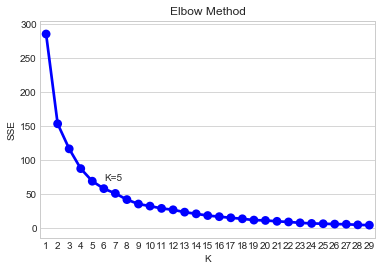

In [219]:
sns.pointplot(x=list(sse_2.keys()), y = list(sse_2.values()), color='blue')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.annotate('K=5', xy =(5,70))

#### Apply K-Means Model: 

In [220]:
#initiatlize kmeans with optimal clusters:
k_m_2 = KMeans(n_clusters=5, random_state=12)

#Fit model:

k_m_2.fit(df_segmented_2_log_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=12, tol=0.0001, verbose=0)

In [221]:
#Generate Cluster labels: 
suppliers=k_m_2.labels_

#Assign cluster labels to segmented table: 
supplier_cluster = segmented_2_log.assign(supplier_labels=suppliers)

In [222]:
#View Table: 
supplier_cluster.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,supplier_labels
supplier,,,,,,
S-0003,1.609438,1.609438,5.956019,0.0,0.693147,0
S-0004,1.386294,0.693147,2.556452,0.0,0.693147,3
S-0005,1.098612,9.097955,10.760000,0.0,3.218876,1
S-0006,1.386294,5.707110,8.954426,0.0,0.693147,3
S-0007,1.791759,7.347300,11.098638,0.0,1.791759,0


#### Build Aggregated Table for the Clusters: 

In [223]:
supplier_agg=supplier_cluster.groupby('supplier_labels').agg({'contract_length_yrs': 'mean',
                                                              'frequency': 'mean',
                                                              'monetary_value': ['mean', 'count'], 
                                                              '%supplier_rebate': ['mean', 'count'],
                                                              'supplier_preference': ['mean', 'count']}).round(decimals= 0) 

In [224]:
#View Table: 
supplier_agg#=segmented_agg.reset_index()

contract_length_yrs frequency monetary_value        \
                               mean      mean           mean count   
supplier_labels                                                      
0                               2.0       4.0            6.0    10   
1                               1.0       9.0           11.0    10   
2                               1.0       5.0            5.0    11   
3                               1.0       4.0            5.0    16   
4                               1.0      12.0           13.0    10   

                %supplier_rebate       supplier_preference        
                            mean count                mean count  
supplier_labels                                                   
0                            0.0    10                 1.0    10  
1                            1.0    10                 3.0    10  
2                            3.0    11                 2.0    11  
3                            0.0    16                 1.0    16  
4                            3.0    10                 7.0    10

In [225]:
#Melt Table
supplier_melt= pd.melt(supplier_cluster.reset_index(), 
                        id_vars=['supplier','supplier_labels'],
                        value_vars=['contract_length_yrs','frequency', 'monetary_value', '%supplier_rebate', 'supplier_preference'],
                        var_name='criteria',
                        value_name='normalized_value')

supplier_melt.head()

,supplier,supplier_labels,criteria,normalized_value
0,S-0003,0,contract_length_yrs,1.609438
1,S-0004,3,contract_length_yrs,1.386294
2,S-0005,1,contract_length_yrs,1.098612
3,S-0006,3,contract_length_yrs,1.386294
4,S-0007,0,contract_length_yrs,1.791759


([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

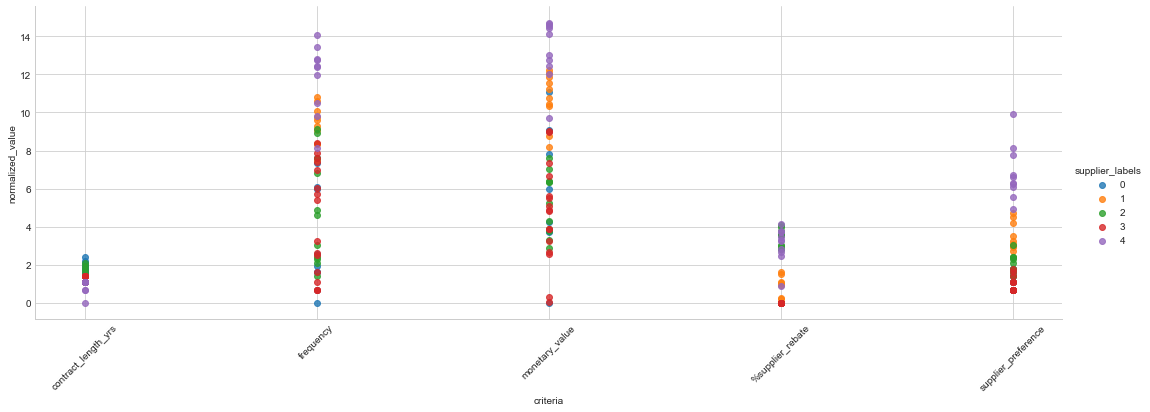

In [226]:
#Plot Criteria Vs Normalized value:
sns.lmplot(x= 'criteria', y = 'normalized_value', data=supplier_melt, fit_reg=False, hue='supplier_labels', size = 5, aspect=3)
plt.xticks(rotation= 45)

Text(116.25,0.5,'Normalized Value')

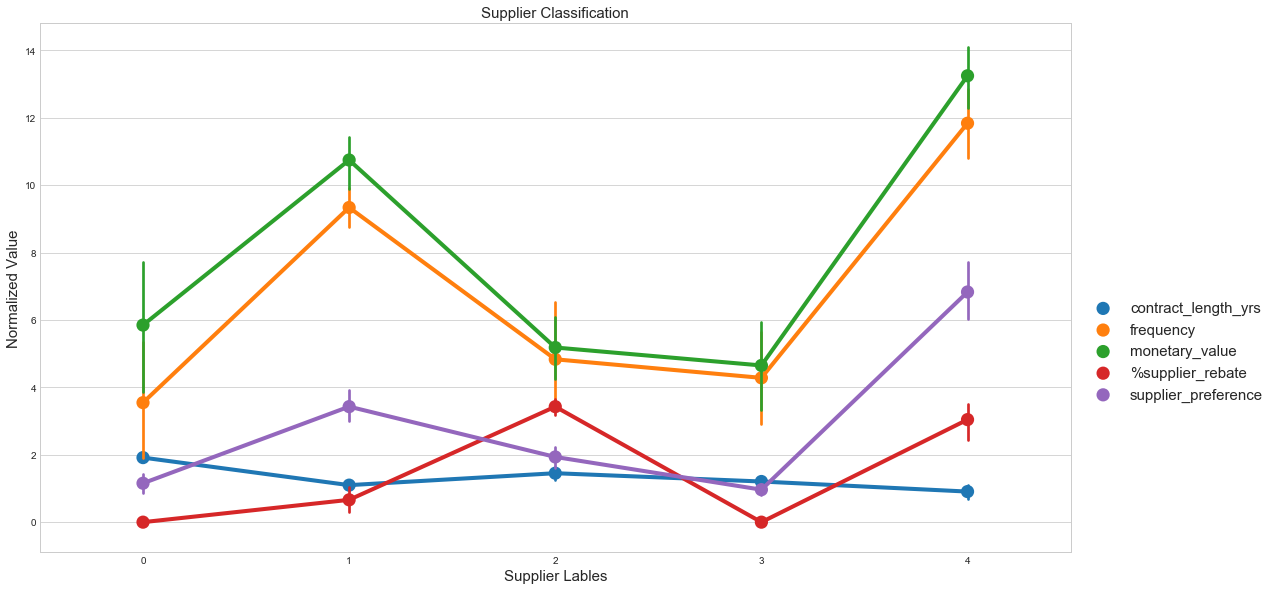

In [227]:
#Plot Supplier Lables against Normalized Value:
plt.figure(figsize= (15,8))
sns.pointplot(x= 'supplier_labels', y = 'normalized_value', data= supplier_melt, hue='criteria', scale = 1.5, fontsize=2)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(1.2, 0.5), fontsize= 15)
plt.title('Supplier Classification', fontsize=15)
plt.xlabel('Supplier Lables', fontsize=15)
plt.ylabel('Normalized Value', fontsize= 15)

In [228]:
# View Supplier Lable 4: 
supplier_melt[supplier_melt['supplier_labels']==4].head()

,supplier,supplier_labels,criteria,normalized_value
9,S-0013,4,contract_length_yrs,0.693147
10,S-0014,4,contract_length_yrs,1.098612
17,S-0026,4,contract_length_yrs,0.000000
22,S-0041,4,contract_length_yrs,1.098612
28,S-0054,4,contract_length_yrs,1.098612


#### Observation: 
1. Supplier labels 4 are highly preferred to manage high spend and frequently ordered assemblies. 
2. Supplier labels 1 needs attention as business has 2nd highest spend but not getting sufficient rebates. 